In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA 
from scipy.cluster.hierarchy import linkage, dendrogram 




In [3]:

db_path = "viewer_interactions.db"
conn = sqlite3.connect(db_path)

df_ratings = pd.read_sql_query("SELECT * FROM viewer_ratings;", conn)
df_movies = pd.read_sql_query("SELECT * FROM movies;", conn)
df_users = pd.read_sql_query("SELECT * FROM user_statistics;", conn)
df_movie_stats = pd.read_sql_query("SELECT * FROM movie_statistics;", conn)


conn.close()

print("Datasets successfully loaded.")

Datasets successfully loaded.


Database overview

In [5]:


db_path = "viewer_interactions.db"
conn = sqlite3.connect(db_path)

tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table';",
    conn
)
print(tables)


for t in tables['name']:
    n = pd.read_sql_query(f"SELECT COUNT(*) AS rows FROM {t};", conn)
    print(f"{t}: {n['rows'][0]} righe")


               name
0    viewer_ratings
1            movies
2   user_statistics
3  movie_statistics
4   data_dictionary
viewer_ratings: 4025000 righe
movies: 18008 righe
user_statistics: 438780 righe
movie_statistics: 16015 righe
data_dictionary: 31 righe


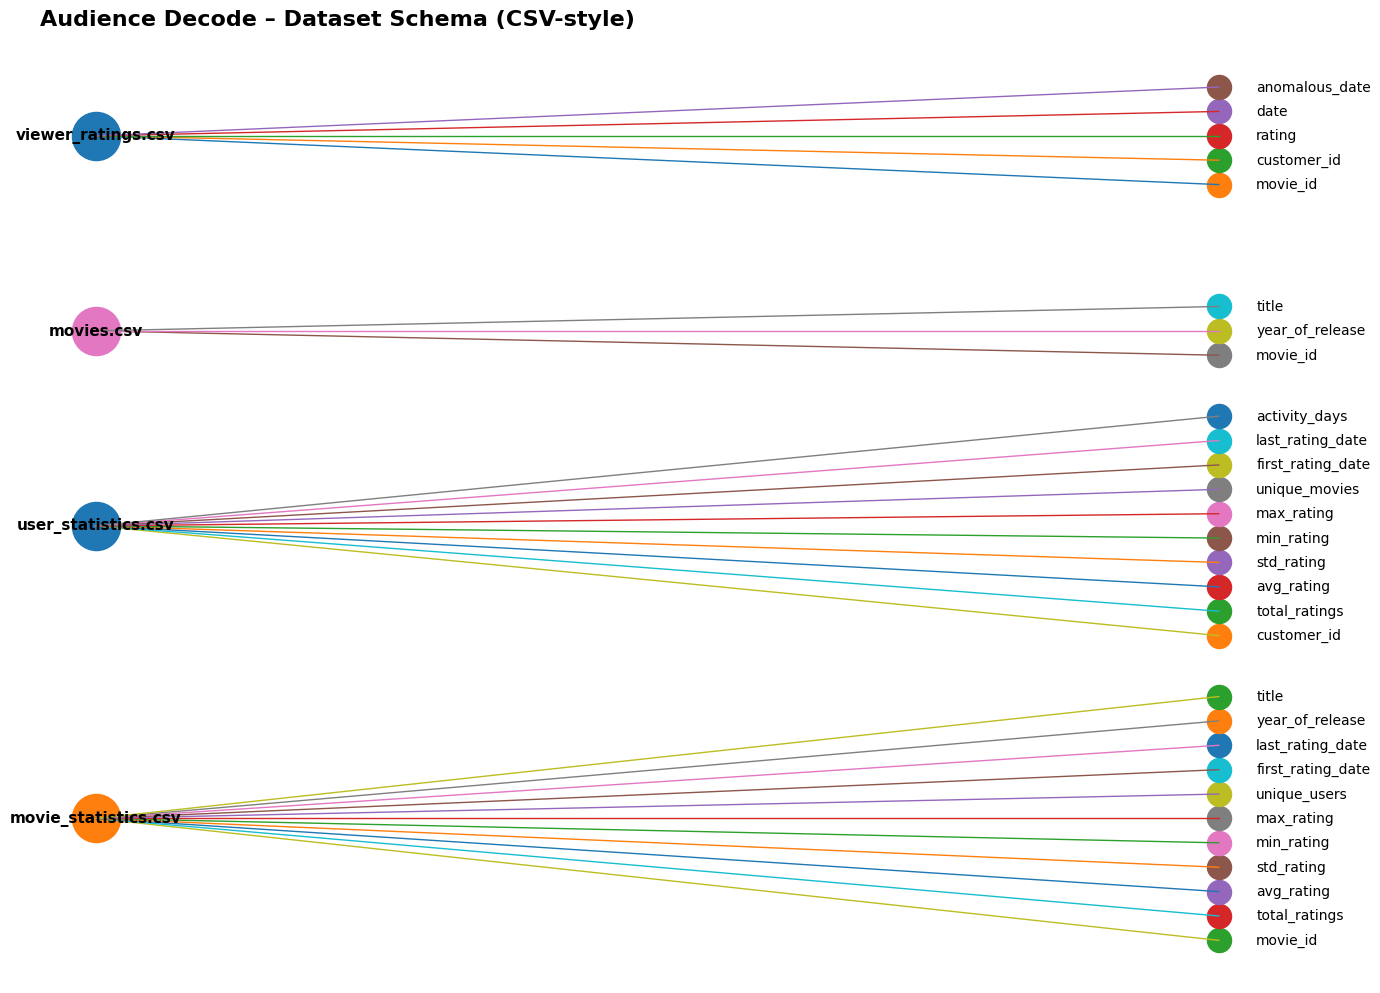

Saved image to: dataset_schema_network.png


In [7]:
schema = {
    "viewer_ratings.csv": list(df_ratings.columns),
    "movies.csv": list(df_movies.columns),
    "user_statistics.csv": list(df_users.columns),
    "movie_statistics.csv": list(df_movie_stats.columns),
}

x_file = 0
x_col = 6
group_gap = 8  
col_gap = 1.0  

positions = {}
labels = {}
edges = []

y = 0
for file_name, cols in schema.items():

    file_node = f"FILE::{file_name}"
    positions[file_node] = (x_file, y)
    labels[file_node] = file_name


    start_y = y - (len(cols) - 1) * col_gap / 2
    for i, col in enumerate(cols):
        col_node = f"COL::{file_name}::{col}"
        col_y = start_y + i * col_gap
        positions[col_node] = (x_col, col_y)
        labels[col_node] = col
        edges.append((file_node, col_node))


    y -= max(group_gap, len(cols) * col_gap + 2)


fig, ax = plt.subplots(figsize=(14, 10))
ax.set_axis_off()


for src, dst in edges:
    x1, y1 = positions[src]
    x2, y2 = positions[dst]
    ax.plot([x1, x2], [y1, y2], linewidth=1)


for node, (xn, yn) in positions.items():
    is_file = node.startswith("FILE::")

    if is_file:
  
        ax.scatter([xn], [yn], s=1200)
        ax.text(
           xn, yn,
           labels[node],
           va="center",
           ha="center",
           fontsize=11,
           fontweight="bold",
           color="black"
    )

    else:
      
        ax.scatter([xn], [yn], s=300)
        ax.text(xn + 0.2, yn, labels[node], va="center", ha="left", fontsize=10)


ax.text(0, 1.02, "Audience Decode – Dataset Schema (CSV-style)", transform=ax.transAxes,
        fontsize=16, fontweight="bold", ha="left")


out_path = "dataset_schema_network.png"
plt.tight_layout()
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved image to: {out_path}")


DATA QUALITY ASSESSMENT

In [8]:
initial_shapes = {
    "ratings": df_ratings.shape,
    "movies": df_movies.shape,
    "users": df_users.shape,
    "movie_stats": df_movie_stats.shape,
}

In [9]:
def missing_table(df):
    total_rows = len(df)
    summary = pd.DataFrame({
        "column": df.columns,
        "total_rows": total_rows,
        "missing_values": df.isna().sum().values,
        "missing_percentage": (df.isna().sum().values / total_rows * 100).round(2)
    })
    return summary
def display_missing_table(df, name):
    print(f"\n=== {name} ===")
    display(missing_table(df))


display_missing_table(df_ratings, "viewer_ratings.csv")
display_missing_table(df_movies, "movies.csv")
display_missing_table(df_users, "user_statistics.csv")
display_missing_table(df_movie_stats, "movie_statistics.csv")




=== viewer_ratings.csv ===


,column,total_rows,missing_values,missing_percentage
0,movie_id,4025000,0,0.00
1,customer_id,4025000,0,0.00
2,rating,4025000,402500,10.00
3,date,4025000,0,0.00
4,anomalous_date,4025000,4023791,99.97



=== movies.csv ===


,column,total_rows,missing_values,missing_percentage
0,movie_id,18008,0,0.00
1,year_of_release,18008,7,0.04
2,title,18008,0,0.00



=== user_statistics.csv ===


,column,total_rows,missing_values,missing_percentage
0,customer_id,438780,0,0.00
1,total_ratings,438780,21939,5.00
2,avg_rating,438780,21939,5.00
3,std_rating,438780,106252,24.22
4,min_rating,438780,21939,5.00
5,max_rating,438780,21939,5.00
6,unique_movies,438780,21939,5.00
7,first_rating_date,438780,0,0.00
8,last_rating_date,438780,0,0.00
9,activity_days,438780,21939,5.00



=== movie_statistics.csv ===


,column,total_rows,missing_values,missing_percentage
0,movie_id,16015,0,0.00
1,total_ratings,16015,800,5.00
2,avg_rating,16015,800,5.00
3,std_rating,16015,9168,57.25
4,min_rating,16015,800,5.00
5,max_rating,16015,800,5.00
6,unique_users,16015,800,5.00
7,first_rating_date,16015,0,0.00
8,last_rating_date,16015,0,0.00
9,year_of_release,16015,4511,28.17


=== viewer_ratings.csv === DATA

In [10]:
import pandas as pd


invalid_mask = (df_ratings["rating"] < 1) | (df_ratings["rating"] > 5)
invalid_ratings = df_ratings.loc[invalid_mask, "rating"]

invalid_summary = (
    invalid_ratings.value_counts()
    .sort_index()
    .reset_index()
)
invalid_summary.columns = ["rating_value", "count"]
invalid_summary["percentage"] = (invalid_summary["count"] / len(df_ratings) * 100).round(4)

print(f"Total invalid ratings: {invalid_mask.sum()}")
display(invalid_summary)

df_ratings.loc[invalid_mask, "rating"] = pd.NA

print("Ratings set to NaN (out of range):")
print(df_ratings["rating"].isna().sum())


user_rating_median = (
    df_ratings.dropna(subset=["rating"])
    .groupby("customer_id")["rating"]
    .median()
)


before_nan = df_ratings["rating"].isna().sum()

nan_mask = df_ratings["rating"].isna()
df_ratings.loc[nan_mask, "rating"] = df_ratings.loc[nan_mask, "customer_id"].map(user_rating_median)

after_nan = df_ratings["rating"].isna().sum()

print(f"NaN ratings before imputation: {before_nan}")
print(f"NaN ratings after user-median imputation: {after_nan}")


before_rows = len(df_ratings)
df_ratings = df_ratings.dropna(subset=["rating"])
after_rows = len(df_ratings)

print(f"Dropped rows with no imputable rating: {before_rows - after_rows}")
print(f"Final dataset size: {df_ratings.shape}")


before_rows = len(df_ratings)
df_ratings = df_ratings[df_ratings["anomalous_date"].isna()]
after_rows = len(df_ratings)

print(f"Dropped rows with anomalous date: {before_rows - after_rows}")
print(f"Remaining rows: {after_rows}")

df_ratings = df_ratings.drop(columns=["anomalous_date"])




Total invalid ratings: 761


,rating_value,count,percentage
0,0.0,385,0.0096
1,6.0,376,0.0093


Ratings set to NaN (out of range):
403261
NaN ratings before imputation: 403261
NaN ratings after user-median imputation: 10810
Dropped rows with no imputable rating: 10810
Final dataset size: (4014190, 5)
Dropped rows with anomalous date: 1112
Remaining rows: 4013078


=== movies.csv === DATA

In [11]:
before = len(df_movies)

df_movies = df_movies.dropna(subset=["year_of_release"])

after = len(df_movies)

print(f"Dropped rows with missing year_of_release: {before - after}")
print(f"Remaining rows: {after}")


Dropped rows with missing year_of_release: 7
Remaining rows: 18001


=== user_statistics.csv ===DATAmi

In [12]:
import pandas as pd

df_users = df_users.copy()

df_users["first_rating_date"] = pd.to_datetime(df_users["first_rating_date"], errors="coerce")
df_users["last_rating_date"] = pd.to_datetime(df_users["last_rating_date"], errors="coerce")

df_users["activity_days"] = (df_users["last_rating_date"] - df_users["first_rating_date"]).dt.days

print("Activity days summary:")
display(df_users["activity_days"].describe())

neg_activity = (df_users["activity_days"] < 0).sum()
missing_activity = df_users["activity_days"].isna().sum()
print("Negative activity_days count:", int(neg_activity))
print("Missing activity_days count:", int(missing_activity))


before = len(df_users)
df_users = df_users.loc[df_users["activity_days"] >= 0].copy()
after = len(df_users)
print(f"Dropped users with negative activity_days: {before - after}")
print(f"Remaining users: {after}")


mask = df_users["total_ratings"].isna()
total_ratings_map = df_ratings.groupby("customer_id")["rating"].count()
df_users.loc[mask, "total_ratings"] = df_users.loc[mask, "customer_id"].map(total_ratings_map)
print("Remaining NaN total_ratings:", int(df_users["total_ratings"].isna().sum()))


mask = df_users["unique_movies"].isna()
unique_movies_map = df_ratings.groupby("customer_id")["movie_id"].nunique()
df_users.loc[mask, "unique_movies"] = df_users.loc[mask, "customer_id"].map(unique_movies_map)
print("Remaining NaN unique_movies:", int(df_users["unique_movies"].isna().sum()))


mask = df_users["avg_rating"].isna()
avg_rating_map = df_ratings.groupby("customer_id")["rating"].mean()
df_users.loc[mask, "avg_rating"] = df_users.loc[mask, "customer_id"].map(avg_rating_map)
print("Remaining NaN avg_rating:", int(df_users["avg_rating"].isna().sum()))

mask = df_users["min_rating"].isna()
min_rating_map = df_ratings.groupby("customer_id")["rating"].min()
df_users.loc[mask, "min_rating"] = df_users.loc[mask, "customer_id"].map(min_rating_map)
print("Remaining NaN min_rating:", int(df_users["min_rating"].isna().sum()))

mask = df_users["max_rating"].isna()
max_rating_map = df_ratings.groupby("customer_id")["rating"].max()
df_users.loc[mask, "max_rating"] = df_users.loc[mask, "customer_id"].map(max_rating_map)
print("Remaining NaN max_rating:", int(df_users["max_rating"].isna().sum()))

before = len(df_users)
df_users = df_users.dropna(subset=["total_ratings", "unique_movies", "avg_rating", "min_rating", "max_rating"]).copy()
after = len(df_users)
print(f"Dropped users with no valid interaction history: {before - after}")
print(f"Remaining users: {after}")


std_map = df_ratings.groupby("customer_id")["rating"].std()

mask_std = df_users["std_rating"].isna()
df_users.loc[mask_std, "std_rating"] = df_users.loc[mask_std, "customer_id"].map(std_map)

single_rating_mask = df_users["std_rating"].isna() & (df_users["total_ratings"] == 1)
df_users.loc[single_rating_mask, "std_rating"] = 0

print("NaN std_rating after recomputation:", int(df_users["std_rating"].isna().sum()))

before = len(df_users)
df_users = df_users.dropna(subset=["std_rating"]).copy()
after = len(df_users)
print(f"Dropped users with unresolved std_rating: {before - after}")
print(f"Remaining users: {after}")



Activity days summary:


count    438780.000000
mean        275.466295
std         388.909126
min        -350.000000
25%           0.000000
50%         102.000000
75%         408.000000
max        3941.000000
Name: activity_days, dtype: float64

Negative activity_days count: 7
Missing activity_days count: 0
Dropped users with negative activity_days: 7
Remaining users: 438773
Remaining NaN total_ratings: 540
Remaining NaN unique_movies: 554
Remaining NaN avg_rating: 591
Remaining NaN min_rating: 568
Remaining NaN max_rating: 557
Dropped users with no valid interaction history: 2549
Remaining users: 436224
NaN std_rating after recomputation: 36
Dropped users with unresolved std_rating: 36
Remaining users: 436188


=== movie_statistics.csv === DATA

In [13]:

mask = df_movie_stats["total_ratings"].isna()
total_ratings_map = df_ratings.groupby("movie_id")["rating"].count()
df_movie_stats.loc[mask, "total_ratings"] = df_movie_stats.loc[mask, "movie_id"].map(total_ratings_map)
print("Remaining NaN total_ratings:", int(df_movie_stats["total_ratings"].isna().sum()))


mask = df_movie_stats["unique_users"].isna()
unique_users_map = df_ratings.groupby("movie_id")["customer_id"].nunique()
df_movie_stats.loc[mask, "unique_users"] = df_movie_stats.loc[mask, "movie_id"].map(unique_users_map)
print("Remaining NaN unique_users:", int(df_movie_stats["unique_users"].isna().sum()))


mask = df_movie_stats["avg_rating"].isna()
avg_rating_map = df_ratings.groupby("movie_id")["rating"].mean()
df_movie_stats.loc[mask, "avg_rating"] = df_movie_stats.loc[mask, "movie_id"].map(avg_rating_map)
print("Remaining NaN avg_rating:", int(df_movie_stats["avg_rating"].isna().sum()))


mask = df_movie_stats["min_rating"].isna()
min_rating_map = df_ratings.groupby("movie_id")["rating"].min()
df_movie_stats.loc[mask, "min_rating"] = df_movie_stats.loc[mask, "movie_id"].map(min_rating_map)
print("Remaining NaN min_rating:", int(df_movie_stats["min_rating"].isna().sum()))

mask = df_movie_stats["max_rating"].isna()
max_rating_map = df_ratings.groupby("movie_id")["rating"].max()
df_movie_stats.loc[mask, "max_rating"] = df_movie_stats.loc[mask, "movie_id"].map(max_rating_map)
print("Remaining NaN max_rating:", int(df_movie_stats["max_rating"].isna().sum()))


std_map = df_ratings.groupby("movie_id")["rating"].std()
mask = df_movie_stats["std_rating"].isna()
df_movie_stats.loc[mask, "std_rating"] = df_movie_stats.loc[mask, "movie_id"].map(std_map)

df_movie_stats.loc[df_movie_stats["total_ratings"] == 1, "std_rating"] = 0
print("Remaining NaN std_rating:", int(df_movie_stats["std_rating"].isna().sum()))


before = len(df_movie_stats)
df_movie_stats = df_movie_stats.dropna(
    subset=["total_ratings", "unique_users", "avg_rating", "min_rating", "max_rating", "std_rating"]
).copy()
after = len(df_movie_stats)

print(f"Dropped movies with unrecoverable statistics: {before - after}")
print(f"Remaining movies: {after}")


df_movie_stats["movie_id"] = pd.to_numeric(df_movie_stats["movie_id"], errors="coerce").astype("Int64")
df_movies["movie_id"] = pd.to_numeric(df_movies["movie_id"], errors="coerce").astype("Int64")

df_movies_unique = df_movies.drop_duplicates(subset=["movie_id"], keep="first")

year_map = df_movies_unique.set_index("movie_id")["year_of_release"]
title_map = df_movies_unique.set_index("movie_id")["title"]

before_year = df_movie_stats["year_of_release"].isna().sum()
before_title = df_movie_stats["title"].isna().sum()

mask = df_movie_stats["year_of_release"].isna()
df_movie_stats.loc[mask, "year_of_release"] = df_movie_stats.loc[mask, "movie_id"].map(year_map)

mask = df_movie_stats["title"].isna()
df_movie_stats.loc[mask, "title"] = df_movie_stats.loc[mask, "movie_id"].map(title_map)

after_year = df_movie_stats["year_of_release"].isna().sum()
after_title = df_movie_stats["title"].isna().sum()

print("Filled year_of_release:", before_year - after_year)
print("Filled title:", before_title - after_title)
print("Remaining NaN year_of_release:", after_year)
print("Remaining NaN title:", after_title)

nan_title = df_movie_stats["title"].isna()
nan_year = df_movie_stats["year_of_release"].isna()

print("NaN title:", int(nan_title.sum()))
print("NaN year_of_release:", int(nan_year.sum()))
print("NaN in BOTH title and year_of_release:", int((nan_title & nan_year).sum()))
print("NaN only in title:", int((nan_title & ~nan_year).sum()))
print("NaN only in year_of_release:", int((~nan_title & nan_year).sum()))



Remaining NaN total_ratings: 59
Remaining NaN unique_users: 74
Remaining NaN avg_rating: 85
Remaining NaN min_rating: 65
Remaining NaN max_rating: 82
Remaining NaN std_rating: 129
Dropped movies with unrecoverable statistics: 398
Remaining movies: 15617
Filled year_of_release: 0
Filled title: 0
Remaining NaN year_of_release: 4389
Remaining NaN title: 4385
NaN title: 4385
NaN year_of_release: 4389
NaN in BOTH title and year_of_release: 4385
NaN only in title: 0
NaN only in year_of_release: 4


In [14]:
def missing_table(df):
    total_rows = len(df)
    return pd.DataFrame({
        "column": df.columns,
        "total_rows": total_rows,
        "missing_values": df.isna().sum().values,
        "missing_percentage": (df.isna().sum().values / total_rows * 100).round(2)
    })


def display_missing(df, name):
    print(f"\n=== {name} ===")
    display(missing_table(df))


# Ristampa finale dopo TUTTO il cleaning
display_missing(df_ratings, "viewer_ratings.csv")
display_missing(df_movies, "movies.csv")
display_missing(df_users, "user_statistics.csv")
display_missing(df_movie_stats, "movie_statistics.csv")



=== viewer_ratings.csv ===


,column,total_rows,missing_values,missing_percentage
0,movie_id,4013078,0,0.0
1,customer_id,4013078,0,0.0
2,rating,4013078,0,0.0
3,date,4013078,0,0.0



=== movies.csv ===


,column,total_rows,missing_values,missing_percentage
0,movie_id,18001,0,0.0
1,year_of_release,18001,0,0.0
2,title,18001,0,0.0



=== user_statistics.csv ===


,column,total_rows,missing_values,missing_percentage
0,customer_id,436188,0,0.0
1,total_ratings,436188,0,0.0
2,avg_rating,436188,0,0.0
3,std_rating,436188,0,0.0
4,min_rating,436188,0,0.0
5,max_rating,436188,0,0.0
6,unique_movies,436188,0,0.0
7,first_rating_date,436188,0,0.0
8,last_rating_date,436188,0,0.0
9,activity_days,436188,0,0.0



=== movie_statistics.csv ===


,column,total_rows,missing_values,missing_percentage
0,movie_id,15617,0,0.00
1,total_ratings,15617,0,0.00
2,avg_rating,15617,0,0.00
3,std_rating,15617,0,0.00
4,min_rating,15617,0,0.00
5,max_rating,15617,0,0.00
6,unique_users,15617,0,0.00
7,first_rating_date,15617,0,0.00
8,last_rating_date,15617,0,0.00
9,year_of_release,15617,4389,28.10


In [16]:
final_shapes = {
    "ratings": df_ratings.shape,
    "movies": df_movies.shape,
    "users": df_users.shape,
    "movie_stats": df_movie_stats.shape,
}

summary = pd.DataFrame({
    "dataset": initial_shapes.keys(),
    "rows_before": [v[0] for v in initial_shapes.values()],
    "rows_after": [v[0] for v in final_shapes.values()],
})

summary["rows_removed"] = summary["rows_before"] - summary["rows_after"]

display(summary)


,dataset,rows_before,rows_after,rows_removed
0,ratings,4025000,4013078,11922
1,movies,18008,18001,7
2,users,438780,436188,2592
3,movie_stats,16015,15617,398


EDA

MERGE

In [17]:
df_users_unique = df_users.drop_duplicates(subset=["customer_id"])
df_movie_stats_unique = (
    df_movie_stats
    .sort_values("total_ratings", ascending=False)
    .drop_duplicates(subset=["movie_id"], keep="first")
)
df_merged = df_ratings.merge(
    df_users_unique,
    on="customer_id",
    how="left"
)

df_merged = df_merged.merge(
    df_movie_stats_unique,
    on="movie_id",
    how="left"
)

assert len(df_merged) == len(df_ratings)
print("Merge OK – row count preserved")

df_merged = df_merged.rename(columns={
    "total_ratings_x": "user_total_ratings",
    "avg_rating_x": "user_avg_rating",
    "std_rating_x": "user_std_rating",
    "min_rating_x": "user_min_rating",
    "max_rating_x": "user_max_rating",
    "unique_movies": "user_unique_movies",

    "total_ratings_y": "movie_total_ratings",
    "avg_rating_y": "movie_avg_rating",
    "std_rating_y": "movie_std_rating",
    "min_rating_y": "movie_min_rating",
    "max_rating_y": "movie_max_rating",
    "unique_users": "movie_unique_users",

    "first_rating_date": "user_first_rating_date",
    "last_rating_date": "user_last_rating_date",
    "activity_days": "user_activity_days",
    "first_rating_date_y": "movie_first_rating_date",
    "last_rating_date_y": "movie_last_rating_date",

})
display(df_merged.head(10))


Merge OK – row count preserved


,movie_id,customer_id,rating,date,user_total_ratings,user_avg_rating,user_std_rating,user_min_rating,user_max_rating,user_unique_movies,...,movie_total_ratings,movie_avg_rating,movie_std_rating,movie_min_rating,movie_max_rating,movie_unique_users,movie_first_rating_date,movie_last_rating_date,year_of_release,title
0,17,1481737,3.0,2005-10-09,6.0,4.000000,0.894427,3.0,5.0,6.0,...,7108.0,2.903208,1.016836,1.0,5.0,7108.0,2005-06-17,2005-12-30,2005.0,7 Seconds
1,9236,1448424,5.0,2005-11-15,15.0,4.000000,1.069045,1.0,5.0,15.0,...,17308.0,4.076013,1.130174,1.0,5.0,17308.0,2003-01-21,2005-12-31,1998.0,South Park: Season 2
2,9330,674346,3.0,2005-04-29,53.0,4.037736,0.831178,2.0,5.0,53.0,...,17108.0,4.008242,0.860934,1.0,5.0,17108.0,1999-01-10,2005-12-31,1965.0,For a Few Dollars More
3,4570,1304045,4.0,2005-09-19,21.0,3.571429,0.597614,3.0,5.0,21.0,...,20704.0,3.352299,0.997178,1.0,5.0,20704.0,1999-12-28,2005-12-31,1997.0,Midnight in the Garden of Good and Evil
4,9320,1036533,5.0,2004-08-05,17.0,4.294118,1.159995,1.0,5.0,17.0,...,9271.0,3.742423,0.938043,1.0,5.0,9271.0,2002-03-07,2005-12-31,1994.0,Iron Will
5,191,2066911,4.0,2003-12-24,13.0,3.538462,0.660225,2.0,4.0,13.0,...,98720.0,3.932202,0.892886,1.0,5.0,98720.0,2003-04-18,2005-12-31,2003.0,X2: X-Men United
6,4590,670110,5.0,2005-05-17,31.0,4.451613,0.888396,1.0,5.0,31.0,...,78721.0,3.342577,1.006366,1.0,5.0,78721.0,2004-08-30,2005-12-31,2004.0,The Forgotten
7,44,707611,5.0,2005-03-13,9.0,4.333333,1.414214,1.0,5.0,9.0,...,8502.0,3.683721,0.970117,1.0,5.0,8502.0,2000-01-06,2005-12-29,1996.0,Spitfire Grill
8,4590,2389674,3.0,2005-09-06,38.0,3.605263,0.916500,2.0,5.0,38.0,...,78721.0,3.342577,1.006366,1.0,5.0,78721.0,2004-08-30,2005-12-31,2004.0,The Forgotten
9,191,1493723,4.0,2005-12-02,6.0,3.833333,0.408248,3.0,4.0,6.0,...,98720.0,3.932202,0.892886,1.0,5.0,98720.0,2003-04-18,2005-12-31,2003.0,X2: X-Men United


In [18]:

print("=== Missing Values (Top 10 columns by percentage) ===")
display(
    df_merged.isna()
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

movie_numeric_cols = [
    "movie_total_ratings",
    "movie_avg_rating",
    "movie_std_rating",
    "movie_min_rating",
    "movie_max_rating",
    "movie_unique_users",
]

rows_any_nan = df_merged[movie_numeric_cols].isna().any(axis=1).sum()
rows_all_nan = df_merged[movie_numeric_cols].isna().all(axis=1).sum()

print("\n=== NaN Diagnostics (Movie Numerical Features) ===")
print("Rows with ANY NaN in movie numerical features:", rows_any_nan)
print("Rows with ALL NaN in movie numerical features:", rows_all_nan)

before = len(df_merged)
df_merged = df_merged.dropna(subset=movie_numeric_cols)
after = len(df_merged)

print("\n=== Row Filtering Summary ===")
print(f"Dropped rows: {before - after}")
print(f"Remaining rows: {after}")
print(f"Percentage dropped: {(before - after) / before * 100:.4f}%")



=== Missing Values (Top 10 columns by percentage) ===


year_of_release            0.001547
title                      0.001546
movie_last_rating_date     0.000017
movie_first_rating_date    0.000017
movie_unique_users         0.000017
movie_max_rating           0.000017
movie_min_rating           0.000017
movie_std_rating           0.000017
movie_avg_rating           0.000017
movie_total_ratings        0.000017
dtype: float64


=== NaN Diagnostics (Movie Numerical Features) ===
Rows with ANY NaN in movie numerical features: 68
Rows with ALL NaN in movie numerical features: 68

=== Row Filtering Summary ===
Dropped rows: 68
Remaining rows: 4013010
Percentage dropped: 0.0017%


EDA

In [ ]:

def classify_content_type(title):
    if pd.isna(title):
        return "unknown"
    title = str(title).lower()
    tv_patterns = [r"\bseason\b", r"\bepisode\b", r"\bseries\b"]
    return "tv_series" if any(re.search(p, title) for p in tv_patterns) else "movie"


if "content_type" not in df_merged.columns:
    df_merged["content_type"] = df_merged["title"].apply(classify_content_type)


rows_summary = df_merged["content_type"].value_counts().to_frame("rows")
rows_summary["percentage"] = (rows_summary["rows"] / rows_summary["rows"].sum() * 100).round(2)


unique_titles = (
    df_merged.dropna(subset=["title"])
    .groupby("content_type")["title"]
    .nunique()
    .to_frame("unique_titles")
)

print("=== Content Type Summary (interaction-level) ===")
display(rows_summary)

print("\n=== Content Type Summary (title-level) ===")
display(unique_titles)



=== Content Type Summary (interaction-level) ===


,rows,percentage
content_type,,
movie,3887801,96.88
tv_series,119074,2.97
unknown,6135,0.15



=== Content Type Summary (title-level) ===


,unique_titles
content_type,
movie,9699
tv_series,567


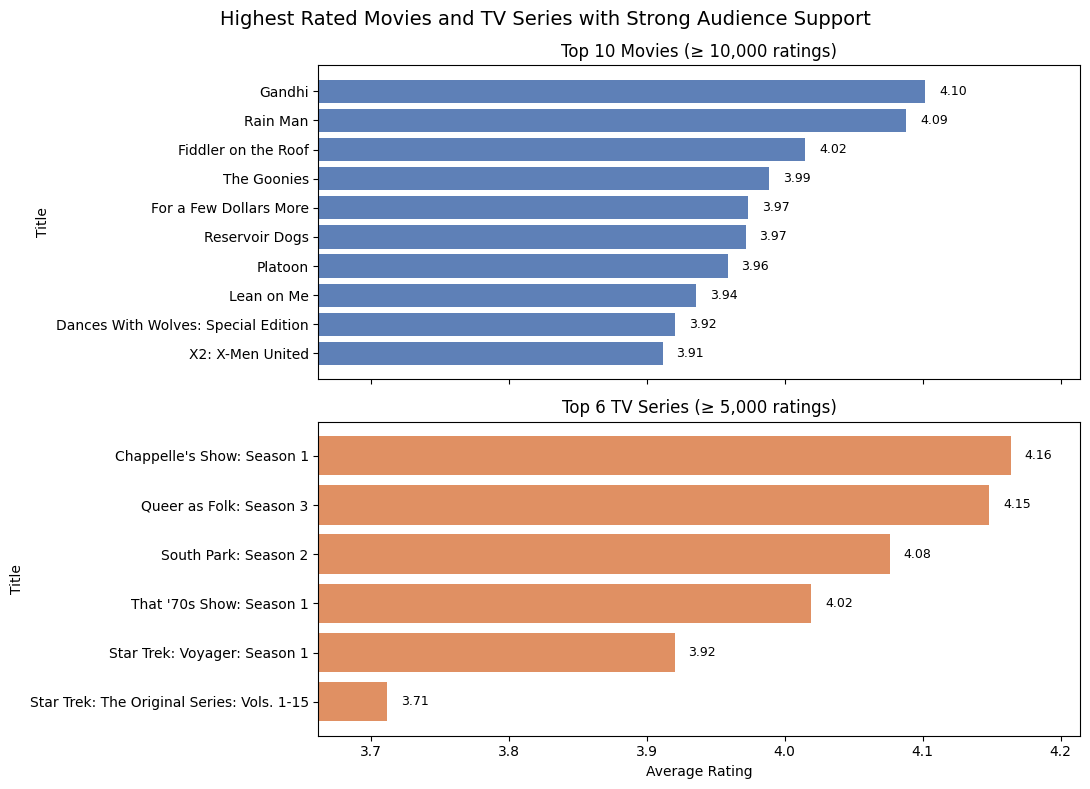

In [47]:

MOVIE_THRESHOLD = 10000
SERIES_THRESHOLD = 5000


agg = (
    df_merged
    .dropna(subset=["title", "rating", "content_type"])
    .groupby(["title", "content_type"])
    .agg(
        total_ratings=("rating", "size"),
        avg_rating=("rating", "mean")
    )
    .reset_index()
)

movies = agg[
    (agg["content_type"] == "movie") &
    (agg["total_ratings"] >= MOVIE_THRESHOLD)
]

series = agg[
    (agg["content_type"] == "tv_series") &
    (agg["total_ratings"] >= SERIES_THRESHOLD)
]


top10_movies = (
    movies.sort_values("avg_rating", ascending=False)
    .head(10)
    .sort_values("avg_rating")
)

top10_series = (
    series.sort_values("avg_rating", ascending=False)
    .head(10)
    .sort_values("avg_rating")
)


xmin = min(
    top10_movies["avg_rating"].min(),
    top10_series["avg_rating"].min()
) - 0.05

xmax = max(
    top10_movies["avg_rating"].max(),
    top10_series["avg_rating"].max()
) + 0.05

fig, axes = plt.subplots(2, 1, figsize=(11, 8), sharex=True)


axes[0].barh(
    top10_movies["title"],
    top10_movies["avg_rating"],
    color="#4C72B0",  
    alpha=0.9
)
axes[0].set_title("Top 10 Movies (≥ 10,000 ratings)", fontsize=12)
axes[0].set_ylabel("Title")
axes[0].set_xlim(xmin, xmax)

for i, v in enumerate(top10_movies["avg_rating"]):
    axes[0].text(v + 0.01, i, f"{v:.2f}", va="center", fontsize=9)


axes[1].barh(
    top10_series["title"],
    top10_series["avg_rating"],
    color="#DD8452",  
    alpha=0.9
)
axes[1].set_title("Top 6 TV Series (≥ 5,000 ratings)", fontsize=12)
axes[1].set_xlabel("Average Rating")
axes[1].set_ylabel("Title")
axes[1].set_xlim(xmin, xmax)

for i, v in enumerate(top10_series["avg_rating"]):
    axes[1].text(v + 0.01, i, f"{v:.2f}", va="center", fontsize=9)

plt.suptitle(
    "Highest Rated Movies and TV Series with Strong Audience Support",
    fontsize=14
)
plt.tight_layout()
plt.show()



Using release-year column: year_of_release


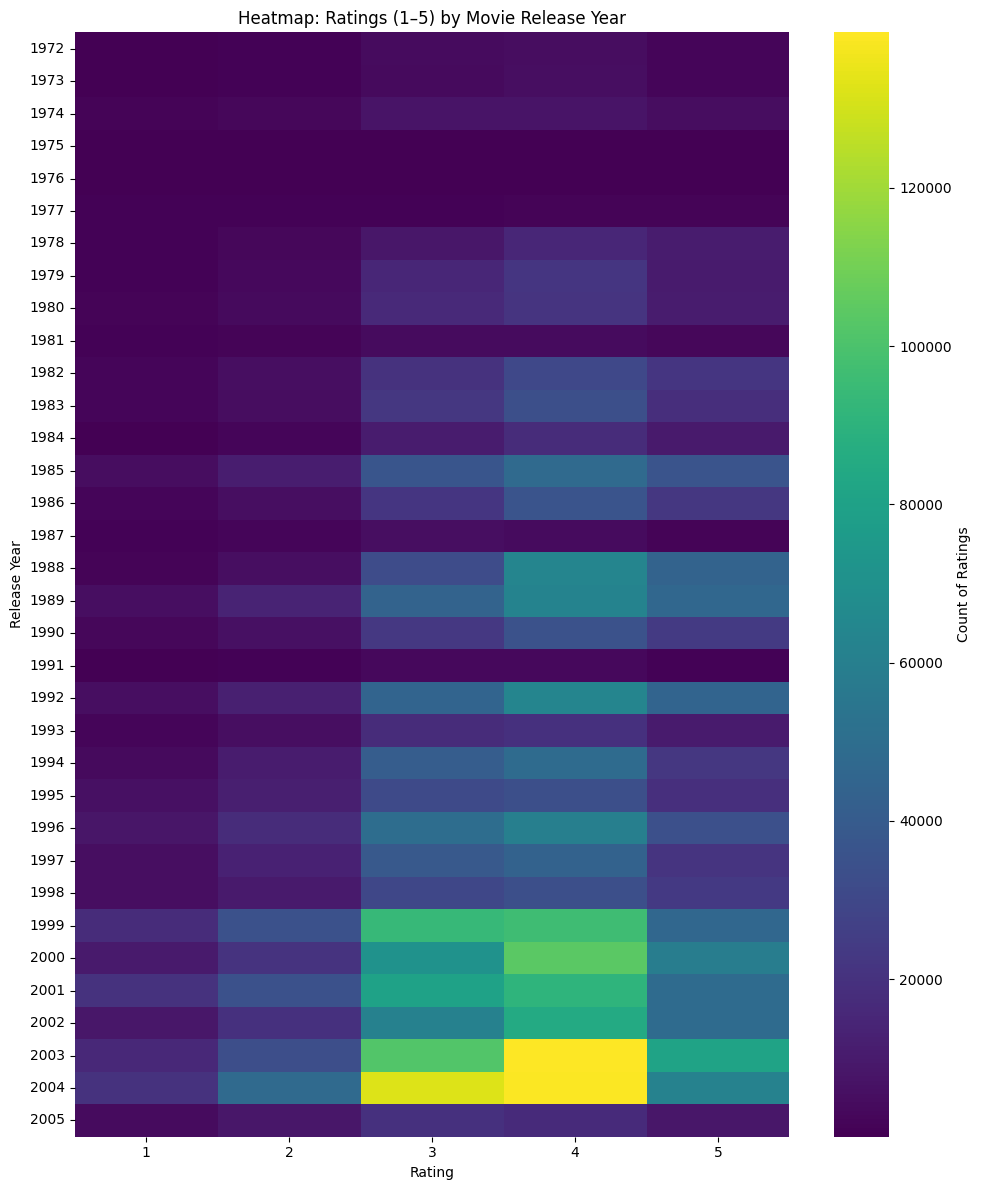

In [21]:

ratings_df = df_ratings.copy()   
year_candidates = ["year_of_release", "year", "release_year", "movie_year", "Year"]
year_col = next((c for c in year_candidates if c in df_movies.columns), None)

if year_col is None:
    raise ValueError(f"Nessuna colonna anno trovata in df_movies. Colonne disponibili: {df_movies.columns.tolist()}")

print("Using release-year column:", year_col)


df_heat = ratings_df.merge(
    df_movies[["movie_id", year_col]],
    left_on="movie_id",
    right_on="movie_id",
    how="left"
)

df_heat[year_col] = (
    df_heat[year_col]
    .astype(str)
    .str.replace(",", "", regex=False)
)
df_heat[year_col] = pd.to_numeric(df_heat[year_col], errors="coerce")


df_heat = df_heat.dropna(subset=[year_col, "rating"])
df_heat[year_col] = df_heat[year_col].astype(int)

df_heat = df_heat[df_heat["rating"].between(1, 5)]
df_heat["rating_int"] = df_heat["rating"].round().astype(int)


df_heat = df_heat[df_heat[year_col] >= 1972]


heatmap_data = df_heat.pivot_table(
    index=year_col,
    columns="rating_int",
    values="customer_id",
    aggfunc="count",
    fill_value=0
)


plt.figure(figsize=(10, 12))
sns.heatmap(
    heatmap_data,
    cmap="viridis",
    annot=False,
    cbar_kws={"label": "Count of Ratings"}
)

plt.title("Heatmap: Ratings (1–5) by Movie Release Year")
plt.xlabel("Rating")
plt.ylabel("Release Year")
plt.tight_layout()
plt.show()



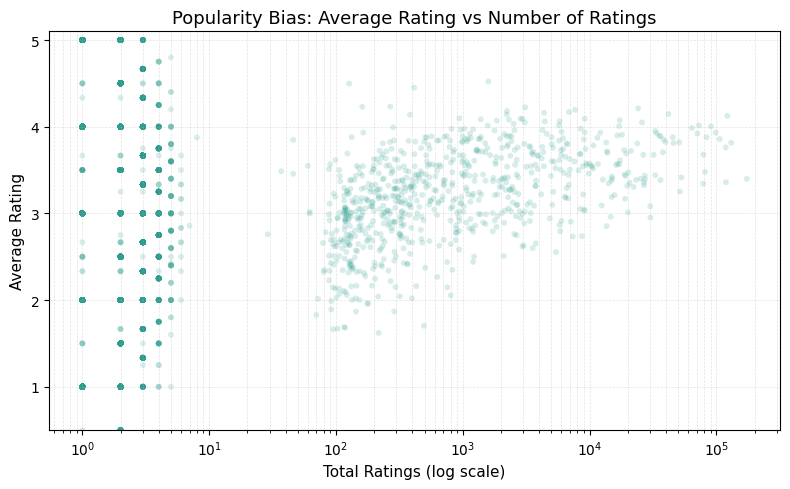

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 5))

plt.scatter(
    df_movie_stats["total_ratings"],
    df_movie_stats["avg_rating"],
    alpha=0.18,
    s=18,
    color="#2A9D8F",          
    edgecolors="none"
)

plt.xscale("log")
plt.xlabel("Total Ratings (log scale)", fontsize=11)
plt.ylabel("Average Rating", fontsize=11)
plt.title(
    "Popularity Bias: Average Rating vs Number of Ratings",
    fontsize=13
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.35)
plt.ylim(0.5, 5.1)

plt.tight_layout()
plt.show()




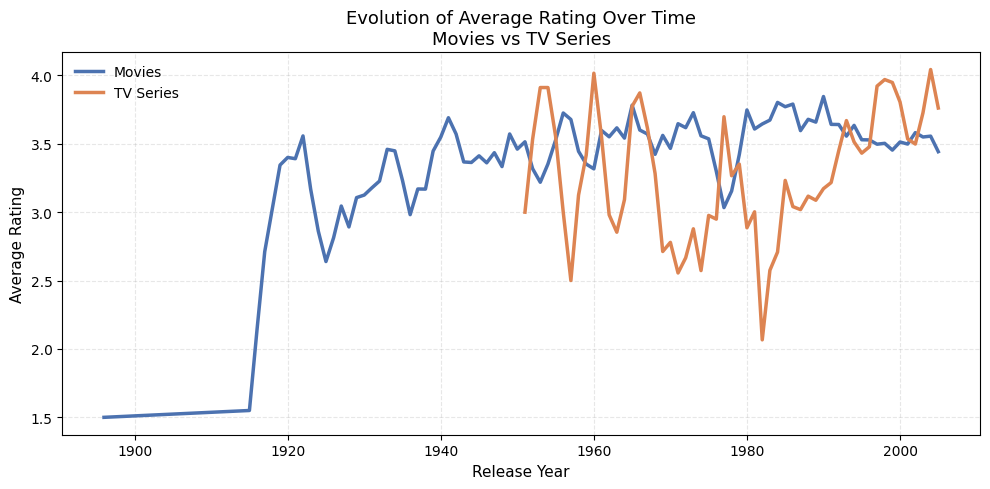

In [23]:

year_col = "movie_year_of_release" if "movie_year_of_release" in df_merged.columns else "year_of_release"

tmp = (
    df_merged
    .dropna(subset=[year_col, "rating", "content_type"])
    .query("content_type in ['movie', 'tv_series']")
    .copy()
)

tmp[year_col] = pd.to_numeric(tmp[year_col], errors="coerce")
tmp = tmp.dropna(subset=[year_col])
tmp[year_col] = tmp[year_col].astype(int)

avg_by_year = (
    tmp.groupby([year_col, "content_type"])["rating"]
    .mean()
    .unstack("content_type")
    .sort_index()
)


avg_smooth = avg_by_year.rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(10, 5))

plt.plot(
    avg_smooth.index,
    avg_smooth["movie"],
    label="Movies",
    color="#4C72B0",
    linewidth=2.5
)

plt.plot(
    avg_smooth.index,
    avg_smooth["tv_series"],
    label="TV Series",
    color="#DD8452",
    linewidth=2.5
)

plt.xlabel("Release Year", fontsize=11)
plt.ylabel("Average Rating", fontsize=11)
plt.title(
    "Evolution of Average Rating Over Time\nMovies vs TV Series",
    fontsize=13
)

plt.grid(alpha=0.3, linestyle="--")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()



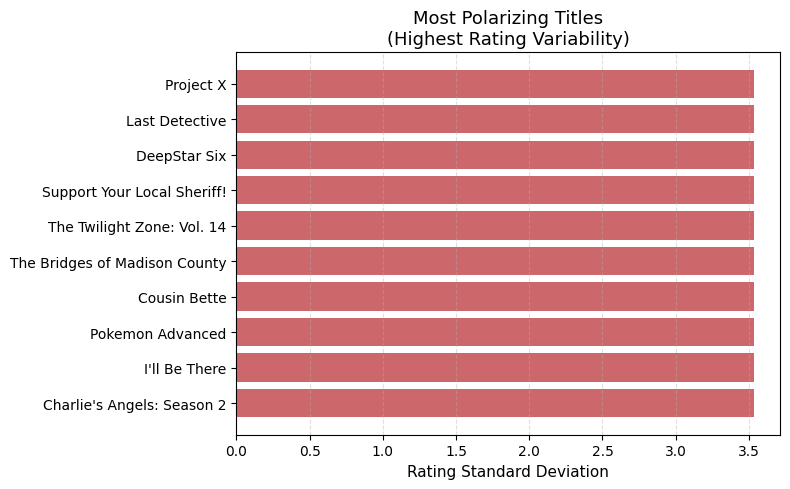

In [56]:
top_polarizing = (
    df_movie_stats
    .dropna(subset=["title", "std_rating"])
    .sort_values("std_rating", ascending=False)
    .head(10)
    .sort_values("std_rating")
)

plt.figure(figsize=(8, 5))

plt.barh(
    top_polarizing["title"].astype(str),
    top_polarizing["std_rating"],
    color="#C44E52",     
    alpha=0.85
)

plt.xlabel("Rating Standard Deviation", fontsize=11)
plt.title(
    "Most Polarizing Titles\n(Highest Rating Variability)",
    fontsize=13
)

plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


REGRESSION

Movies before filter: 14531
Movies after  filter: 772
Rule: >= 30 ratings within first 30 active days

Train: (617, 8) Test: (155, 8)

=== Regression performance (log-scale) ===
RMSE: 1.4095
MAE:  1.1055
R²:   0.4528


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


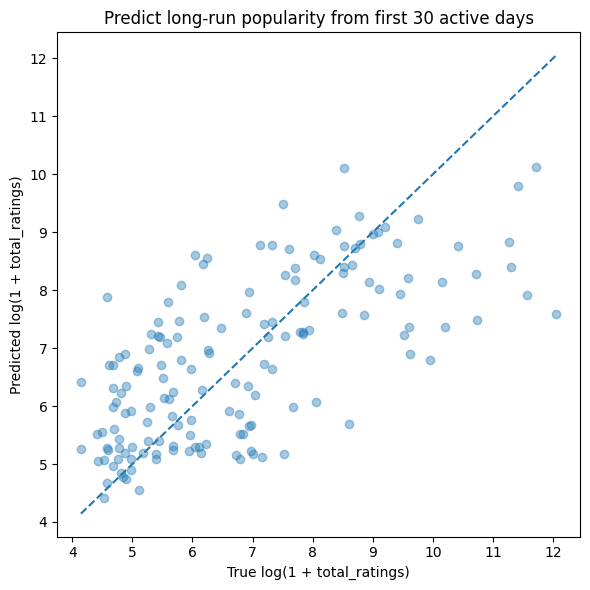

In [46]:

K_ACTIVE_DAYS =   30     
MIN_RATINGS_IN_K_DAYS =   30   
TEST_SIZE = 0.2
RANDOM_STATE = 42


ratings = df_ratings.copy()
ratings["date"] = pd.to_datetime(ratings["date"], errors="coerce")
ratings = ratings.dropna(subset=["movie_id", "customer_id", "rating", "date"])
ratings["rating"] = pd.to_numeric(ratings["rating"], errors="coerce")
ratings = ratings.dropna(subset=["rating"])
ratings = ratings[ratings["rating"].between(1, 5)]


ratings["day"] = ratings["date"].dt.date

launch_day = ratings.groupby("movie_id")["day"].min().rename("launch_day")
ratings = ratings.merge(launch_day, on="movie_id", how="left")

active_days = (
    ratings[["movie_id", "day"]]
    .drop_duplicates()
    .sort_values(["movie_id", "day"])
)

active_days["active_day_index"] = active_days.groupby("movie_id").cumcount() + 1  
ratings = ratings.merge(active_days, on=["movie_id", "day"], how="left")


early = ratings[ratings["active_day_index"] <= K_ACTIVE_DAYS].copy()

early_feat = early.groupby("movie_id").agg(
    early_ratings_count=("rating", "size"),
    early_unique_users=("customer_id", "nunique"),
    early_avg_rating=("rating", "mean"),
    early_std_rating=("rating", "std"),
    early_min_rating=("rating", "min"),
    early_max_rating=("rating", "max"),
    early_active_days=("day", "nunique"),
).reset_index()

early_feat["early_std_rating"] = early_feat["early_std_rating"].fillna(0)
early_feat["ratings_per_active_day"] = early_feat["early_ratings_count"] / early_feat["early_active_days"].clip(lower=1)


before = len(early_feat)
early_feat = early_feat[early_feat["early_ratings_count"] >= MIN_RATINGS_IN_K_DAYS].copy()
after = len(early_feat)

print(f"Movies before filter: {before}")
print(f"Movies after  filter: {after}")
print(f"Rule: >= {MIN_RATINGS_IN_K_DAYS} ratings within first {K_ACTIVE_DAYS} active days")


total_counts = ratings.groupby("movie_id").size().rename("total_ratings")
early_feat = early_feat.merge(total_counts, on="movie_id", how="left")

early_feat["log_total_ratings"] = np.log1p(early_feat["total_ratings"])

features = [
    "early_ratings_count",
    "early_unique_users",
    "early_avg_rating",
    "early_std_rating",
    "early_min_rating",
    "early_max_rating",
    "early_active_days",
    "ratings_per_active_day",
]

X = early_feat[features]
y = early_feat["log_total_ratings"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("\nTrain:", X_train.shape, "Test:", X_test.shape)


model = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
pred = model.predict(X_test)

rmse = mean_squared_error(y_test, pred, squared=False)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print("\n=== Regression performance (log-scale) ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")


plt.figure(figsize=(6, 6))
plt.scatter(y_test, pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("True log(1 + total_ratings)")
plt.ylabel("Predicted log(1 + total_ratings)")
plt.title(f"Predict long-run popularity from first {K_ACTIVE_DAYS} active days")
plt.tight_layout()
plt.show()


CLUSTERING

In [25]:


if "ratings" in globals() and isinstance(ratings, pd.DataFrame):
    events = ratings.copy()
elif "ratings_df" in globals() and isinstance(ratings_df, pd.DataFrame):
    events = ratings_df.copy()
elif "df_ratings" in globals() and isinstance(df_ratings, pd.DataFrame):
    events = df_ratings.copy()
else:
    raise NameError("Non trovo il dataframe eventi. Usa clean oppure ratings/ratings_df/df_ratings.")

events["rating"] = pd.to_numeric(events["rating"], errors="coerce")
events = events[events["rating"].between(0, 5)]
events["date"] = pd.to_datetime(events["date"], errors="coerce")


user_stats = events.groupby("customer_id").agg(
    total_ratings=("rating", "count"),
    avg_rating=("rating", "mean"),
    std_rating=("rating", "std"),
    min_rating=("rating", "min"),
    max_rating=("rating", "max"),
    unique_movies=("movie_id", "nunique"),
    activity_days=("date", lambda s: (s.max()-s.min()).days if s.notna().sum() > 1 else 0)
).reset_index()

user_stats["std_rating"] = user_stats["std_rating"].fillna(0)
user_stats["activity_days"] = user_stats["activity_days"].fillna(0)
user_stats["ratings_per_day"] = user_stats["total_ratings"] / (user_stats["activity_days"] + 1)
user_stats["generosity"] = user_stats["avg_rating"] - 3.0
user_stats["lifetime_intensity"] = (
    user_stats["total_ratings"] / np.sqrt(user_stats["activity_days"] + 1)
)



features_A_users = ["total_ratings", "activity_days", "ratings_per_day", "unique_movies"]
XA_users_df = user_stats[features_A_users].copy()
for c in XA_users_df.columns:
    XA_users_df[c] = np.log1p(XA_users_df[c])
scaler_A_users = StandardScaler()
XA_users = scaler_A_users.fit_transform(XA_users_df)


features_B_users = ["avg_rating", "std_rating", "min_rating", "max_rating", "generosity"]
XB_users_df = user_stats[features_B_users].copy()
scaler_B_users = StandardScaler()
XB_users = scaler_B_users.fit_transform(XB_users_df)


movie_stats = events.groupby("movie_id").agg(
    total_ratings=("rating", "count"),
    avg_rating=("rating", "mean"),
    std_rating=("rating", "std"),
    min_rating=("rating", "min"),
    max_rating=("rating", "max"),
    unique_users=("customer_id", "nunique"),
    activity_days=("date", lambda s: (s.max()-s.min()).days if s.notna().sum() > 1 else 0)
).reset_index()

movie_stats["std_rating"] = movie_stats["std_rating"].fillna(0)
movie_stats["activity_days"] = movie_stats["activity_days"].fillna(0)
movie_stats["ratings_per_day"] = movie_stats["total_ratings"] / (movie_stats["activity_days"] + 1)
movie_stats["polarization"] = movie_stats["std_rating"]


features_A_movies = ["total_ratings", "unique_users", "activity_days", "ratings_per_day"]
XA_movies_df = movie_stats[features_A_movies].copy()
for c in XA_movies_df.columns:
    XA_movies_df[c] = np.log1p(XA_movies_df[c])
scaler_A_movies = StandardScaler()
XA_movies = scaler_A_movies.fit_transform(XA_movies_df)


features_B_movies = ["avg_rating", "std_rating", "min_rating", "max_rating", "polarization"]
XB_movies_df = movie_stats[features_B_movies].copy()
scaler_B_movies = StandardScaler()
XB_movies = scaler_B_movies.fit_transform(XB_movies_df)

print("Events rows (righe):", events.shape[0])

print("\n--- USERS ---")
print("Users rows:", user_stats.shape[0])
print("XA_users shape (A):", XA_users.shape, "| Features:", features_A_users)
print("XB_users shape (B):", XB_users.shape, "| Features:", features_B_users)

print("\n--- MOVIES ---")
print("Movies rows:", movie_stats.shape[0])
print("XA_movies shape (A):", XA_movies.shape, "| Features:", features_A_movies)
print("XB_movies shape (B):", XB_movies.shape, "| Features:", features_B_movies)




Events rows (righe): 4013078

--- USERS ---
Users rows: 427529
XA_users shape (A): (427529, 4) | Features: ['total_ratings', 'activity_days', 'ratings_per_day', 'unique_movies']
XB_users shape (B): (427529, 5) | Features: ['avg_rating', 'std_rating', 'min_rating', 'max_rating', 'generosity']

--- MOVIES ---
Movies rows: 14531
XA_movies shape (A): (14531, 4) | Features: ['total_ratings', 'unique_users', 'activity_days', 'ratings_per_day']
XB_movies shape (B): (14531, 5) | Features: ['avg_rating', 'std_rating', 'min_rating', 'max_rating', 'polarization']


In [ ]:


pca_users_A = PCA(n_components=2, random_state=42)
XA_users_pca = pca_users_A.fit_transform(XA_users)


pca_users_B = PCA(n_components=2, random_state=42)
XB_users_pca = pca_users_B.fit_transform(XB_users)


pca_movies_A = PCA(n_components=2, random_state=42)
XA_movies_pca = pca_movies_A.fit_transform(XA_movies)


pca_movies_B = PCA(n_components=2, random_state=42)
XB_movies_pca = pca_movies_B.fit_transform(XB_movies)

print("PCA READY:")
print("XA_users_pca :", XA_users_pca.shape)
print("XB_users_pca :", XB_users_pca.shape)
print("XA_movies_pca:", XA_movies_pca.shape)
print("XB_movies_pca:", XB_movies_pca.shape)

PCA READY:
XA_users_pca : (427529, 2)
XB_users_pca : (427529, 2)
XA_movies_pca: (14531, 2)
XB_movies_pca: (14531, 2)


CLUSTERING A —- MOVIE BEHAVIOR

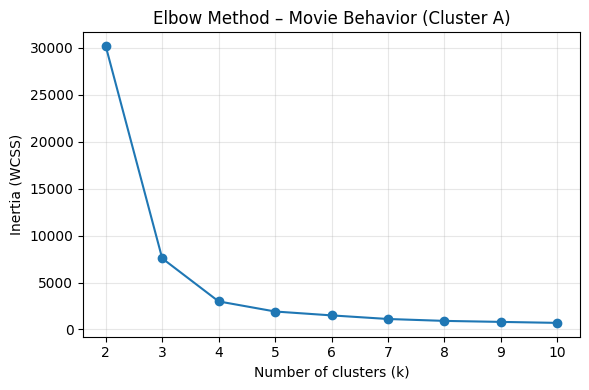

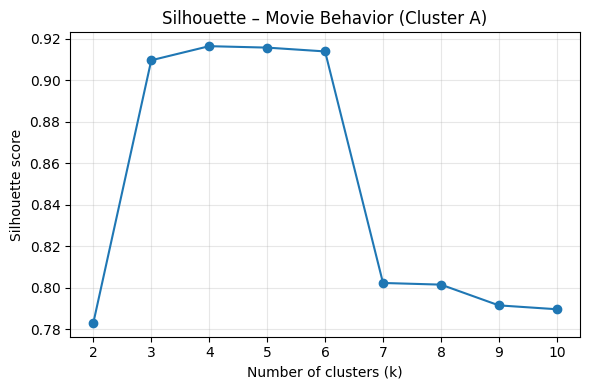

In [28]:

K = range(2, 11)
inertia = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(XA_movies)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K), inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method – Movie Behavior (Cluster A)")
plt.xticks(list(K))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


sil_scores = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(XA_movies)
    sil_scores.append(silhouette_score(XA_movies, labels))

plt.figure(figsize=(6,4))
plt.plot(list(K), sil_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette – Movie Behavior (Cluster A)")
plt.xticks(list(K))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [29]:
best_k_A_movies = K[sil_scores.index(max(sil_scores))]
print("Best k from silhouette:", best_k_A_movies)
kA_movies = best_k_A_movies 

kmeans_A_movies = KMeans(
    n_clusters=kA_movies,
    random_state=42,
    n_init=20
)

labels_A_movies = kmeans_A_movies.fit_predict(XA_movies)

movie_stats["cluster_A_movie"] = labels_A_movies
cluster_profile = (
    movie_stats
    .groupby("cluster_A_movie")[features_A_movies]
    .mean()
)

display(cluster_profile)



Best k from silhouette: 4


,total_ratings,unique_users,activity_days,ratings_per_day
cluster_A_movie,,,,
0,665.630584,665.630584,1326.589347,0.579676
1,1.002754,1.002754,0.010902,0.998652
2,2.357511,2.357511,894.256441,0.008151
3,19074.322751,19074.312169,1448.761905,15.101145


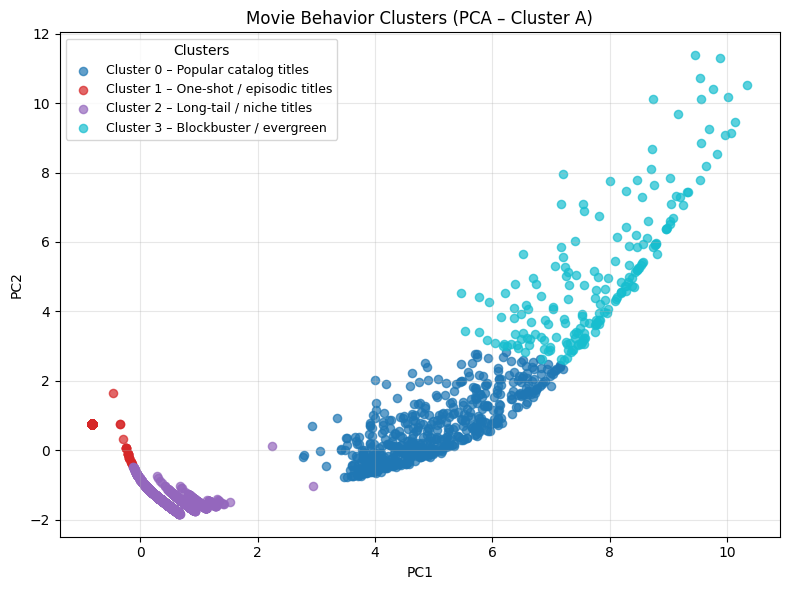

In [30]:
cluster_names = {
    0: "Popular catalog titles",
    1: "One-shot / episodic titles",
    2: "Long-tail / niche titles",
    3: "Blockbuster / evergreen"
}
cluster_colors = {
    0: "#1f77b4", 
    1: "#d62728",  
    2: "#9467bd",  
    3: "#17becf"   
}
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for c in np.unique(labels_A_movies):
    idx = labels_A_movies == c
    plt.scatter(
        XA_movies_pca[idx, 0],
        XA_movies_pca[idx, 1],
        c=cluster_colors[c],
        label=f"Cluster {c} – {cluster_names[c]}",
        alpha=0.7,
        s=35
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Movie Behavior Clusters (PCA – Cluster A)")
plt.legend(title="Clusters", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


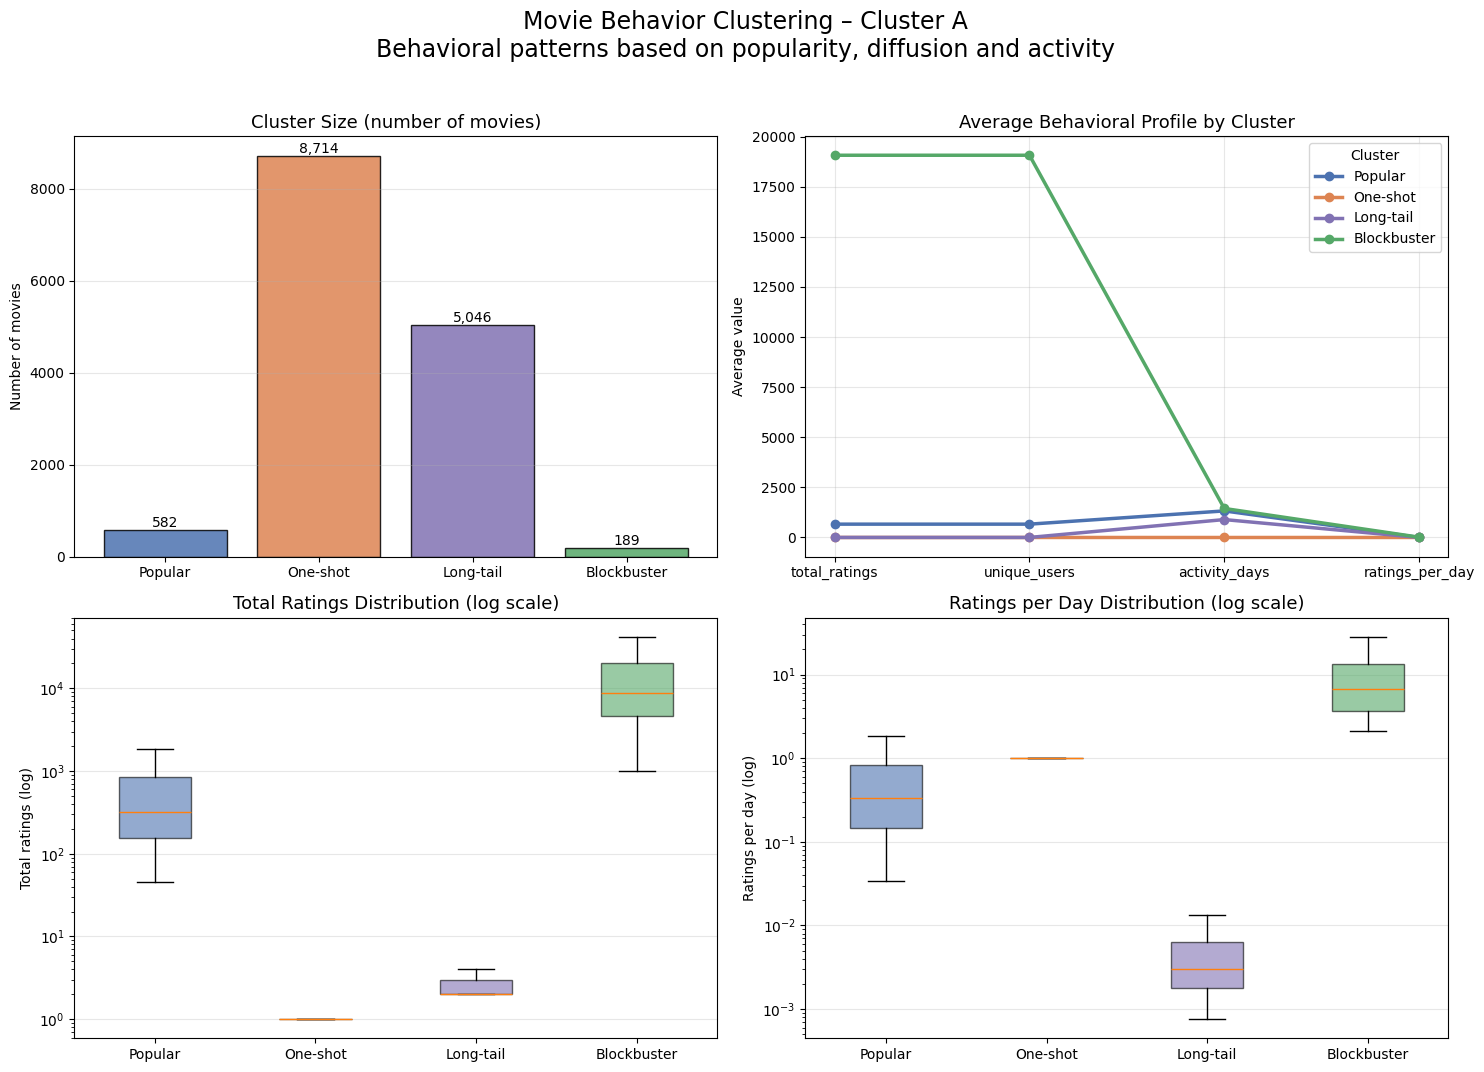

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


cluster_names_short = {
    0: "Popular",
    1: "One-shot",
    2: "Long-tail",
    3: "Blockbuster"
}

cluster_names_long = {
    0: "Popular catalog titles",
    1: "One-shot / episodic titles",
    2: "Long-tail / niche titles",
    3: "Blockbuster / evergreen"
}

cluster_colors = {
    0: "#4C72B0",
    1: "#DD8452",
    2: "#8172B3",
    3: "#55A868"
}

clusters = sorted(movie_stats["cluster_A_movie"].unique())
features = features_A_movies

cluster_size = movie_stats["cluster_A_movie"].value_counts().sort_index()
cluster_mean = movie_stats.groupby("cluster_A_movie")[features].mean()


fig, axes = plt.subplots(2, 2, figsize=(15, 11))
fig.suptitle(
    "Movie Behavior Clustering – Cluster A\n"
    "Behavioral patterns based on popularity, diffusion and activity",
    fontsize=17,
    y=0.97
)


ax = axes[0, 0]
bars = ax.bar(
    cluster_size.index,
    cluster_size.values,
    color=[cluster_colors[c] for c in cluster_size.index],
    edgecolor="black",
    alpha=0.85
)

ax.set_title("Cluster Size (number of movies)", fontsize=13)
ax.set_xticks(cluster_size.index)
ax.set_xticklabels(
    [cluster_names_short[c] for c in cluster_size.index],
    rotation=0
)
ax.set_ylabel("Number of movies")
ax.grid(axis="y", alpha=0.3)


for b in bars:
    ax.text(
        b.get_x() + b.get_width() / 2,
        b.get_height(),
        f"{int(b.get_height()):,}",
        ha="center",
        va="bottom",
        fontsize=10
    )


ax = axes[0, 1]
for c in cluster_mean.index:
    ax.plot(
        features,
        cluster_mean.loc[c],
        marker="o",
        linewidth=2.5,
        label=cluster_names_short[c],
        color=cluster_colors[c]
    )

ax.set_title("Average Behavioral Profile by Cluster", fontsize=13)
ax.set_ylabel("Average value")
ax.grid(alpha=0.3)
ax.legend(title="Cluster")


ax = axes[1, 0]
data = [
    movie_stats.loc[movie_stats["cluster_A_movie"] == c, "total_ratings"]
    for c in clusters
]

bp = ax.boxplot(
    data,
    labels=[cluster_names_short[c] for c in clusters],
    patch_artist=True,
    showfliers=False
)

for patch, c in zip(bp["boxes"], clusters):
    patch.set_facecolor(cluster_colors[c])
    patch.set_alpha(0.6)
    patch.set_edgecolor("black")

ax.set_yscale("log")
ax.set_title("Total Ratings Distribution (log scale)", fontsize=13)
ax.set_ylabel("Total ratings (log)")
ax.grid(axis="y", alpha=0.3)


ax = axes[1, 1]
data = [
    movie_stats.loc[movie_stats["cluster_A_movie"] == c, "ratings_per_day"]
    for c in clusters
]

bp = ax.boxplot(
    data,
    labels=[cluster_names_short[c] for c in clusters],
    patch_artist=True,
    showfliers=False
)

for patch, c in zip(bp["boxes"], clusters):
    patch.set_facecolor(cluster_colors[c])
    patch.set_alpha(0.6)
    patch.set_edgecolor("black")

ax.set_yscale("log")
ax.set_title("Ratings per Day Distribution (log scale)", fontsize=13)
ax.set_ylabel("Ratings per day (log)")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


CLUSTER A USER BEHAVIOR

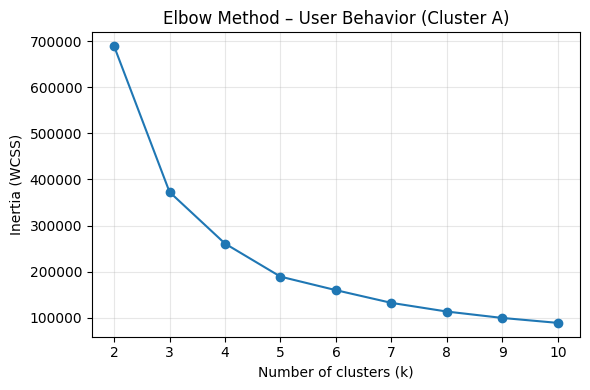

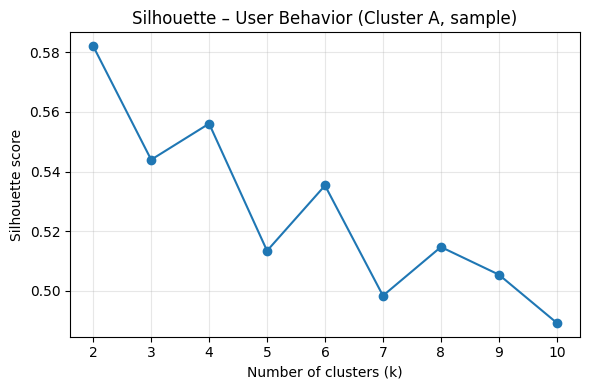

In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

K = range(2, 11)
inertia = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(XA_users)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K), inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method – User Behavior (Cluster A)")
plt.xticks(list(K))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



rng = np.random.default_rng(42)
sample_size = 50000
sample_idx = rng.choice(
    XA_users.shape[0],
    size=min(sample_size, XA_users.shape[0]),
    replace=False
)
XA_users_sample = XA_users[sample_idx]

sil_scores = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(XA_users_sample)
    sil_scores.append(silhouette_score(XA_users_sample, labels))

plt.figure(figsize=(6,4))
plt.plot(list(K), sil_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette – User Behavior (Cluster A, sample)")
plt.xticks(list(K))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Con 427k utenti la silhouette full è costosa → usiamo un sample (best practice).

In [33]:
kA_users = 4  

kmeans_A_users = KMeans(
    n_clusters=kA_users,
    random_state=42,
    n_init=20
)

labels_A_users = kmeans_A_users.fit_predict(XA_users)

user_stats["cluster_A_user"] = labels_A_users


cluster_profile_users = (
    user_stats
    .groupby("cluster_A_user")[features_A_users]
    .mean()
)

display(cluster_profile_users)

,total_ratings,activity_days,ratings_per_day,unique_movies
cluster_A_user,,,,
0,23.438581,583.450357,0.101811,23.438573
1,5.688935,0.407164,4.574940,5.688935
2,1.300613,0.147936,1.218457,1.300613
3,4.826120,284.459487,0.063765,4.826115


/var/folders/7w/xlbnwxy940s26zqjfml1w50w0000gn/T/ipykernel_1331/1469943751.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


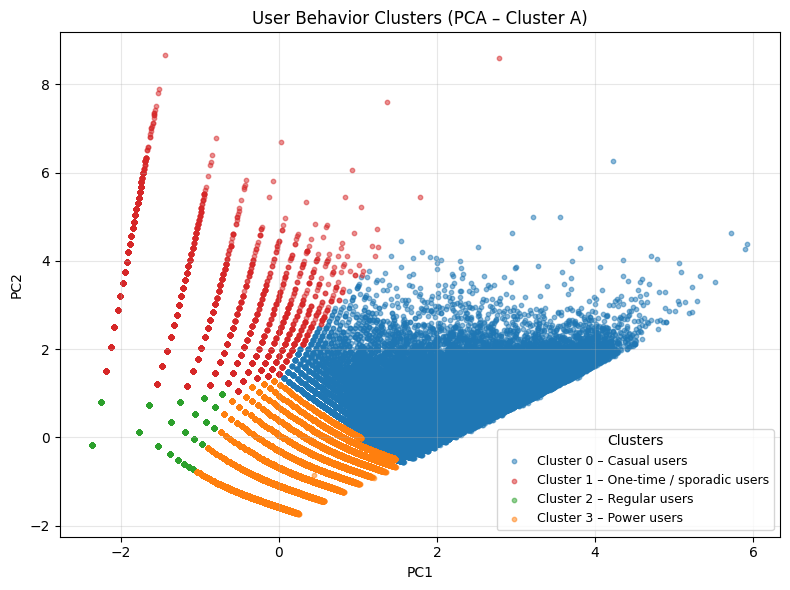

In [ ]:
cluster_names_users = {
    0: "Casual users",
    1: "One-time / sporadic users",
    2: "Regular users",
    3: "Power users"
}

cluster_colors_users = {
    0: "#1f77b4",  
    1: "#d62728",  
    2: "#2ca02c",  
    3: "#ff7f0e"   
}


plt.figure(figsize=(8,6))

for c in np.unique(labels_A_users):
    idx = labels_A_users == c
    plt.scatter(
        XA_users_pca[idx, 0],
        XA_users_pca[idx, 1],
        c=cluster_colors_users[c],
        label=f"Cluster {c} – {cluster_names_users[c]}",
        alpha=0.5,
        s=10
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("User Behavior Clusters (PCA – Cluster A)")
plt.legend(title="Clusters", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


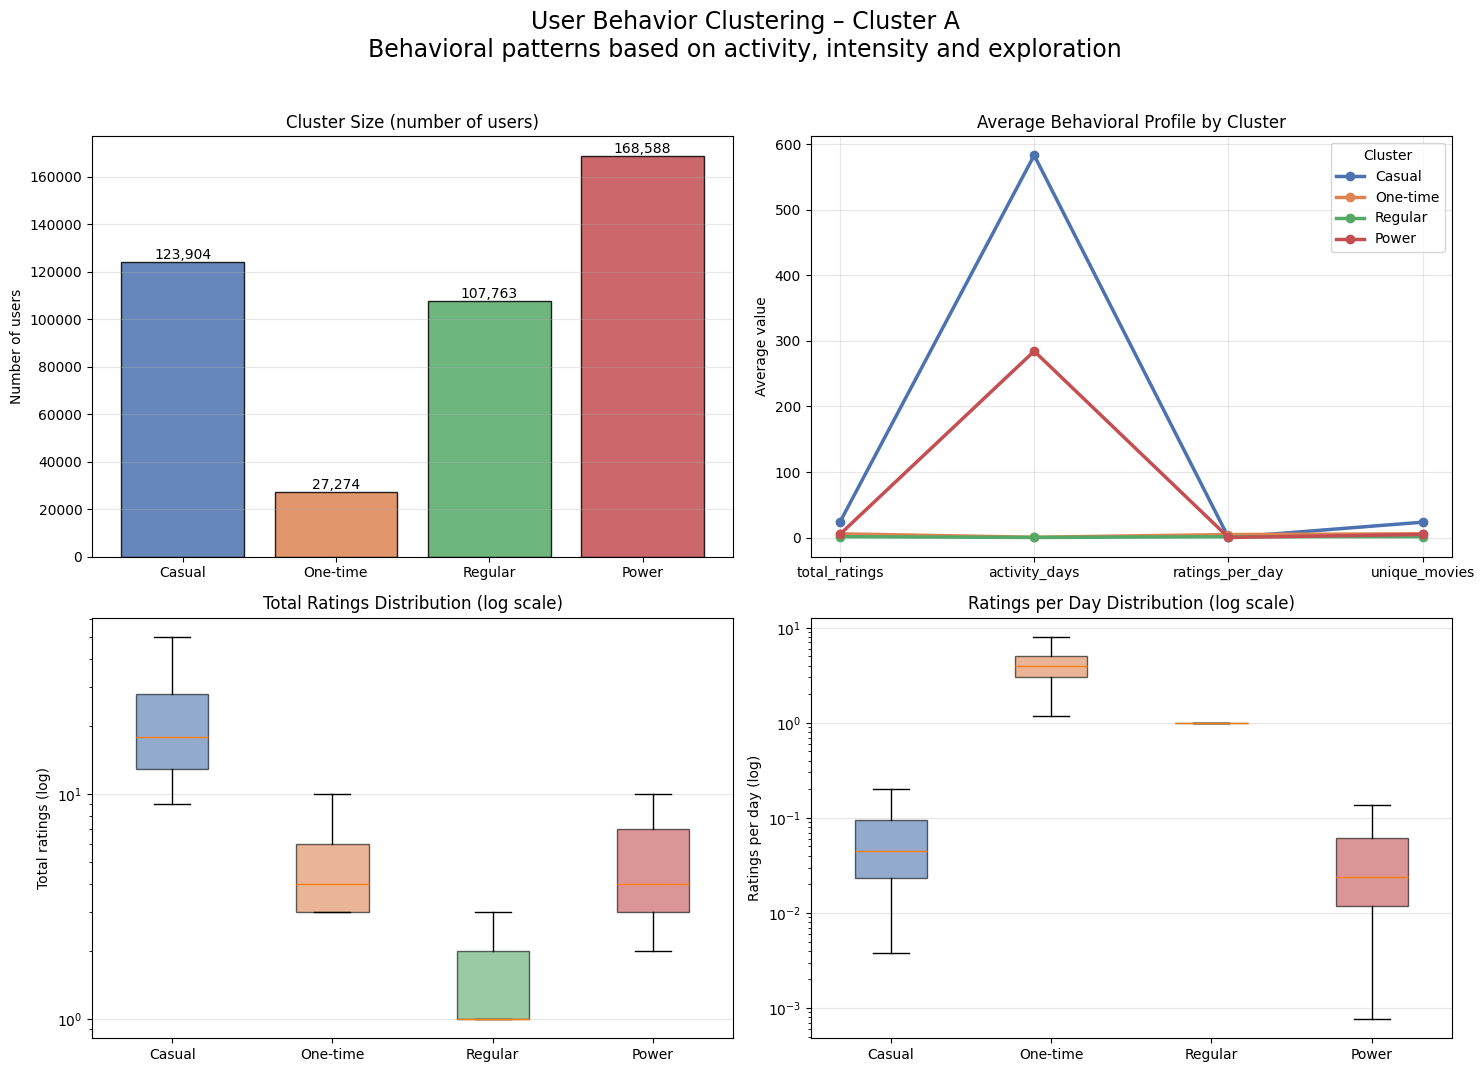

In [35]:
import numpy as np
import matplotlib.pyplot as plt


cluster_names_users = {
    0: "Casual",
    1: "One-time",
    2: "Regular",
    3: "Power"
}

cluster_colors_users = {
    0: "#4C72B0",
    1: "#DD8452",
    2: "#55A868",
    3: "#C44E52"
}

clusters = sorted(user_stats["cluster_A_user"].unique())
features = features_A_users

cluster_size = user_stats["cluster_A_user"].value_counts().sort_index()
cluster_mean = user_stats.groupby("cluster_A_user")[features].mean()

fig, axes = plt.subplots(2, 2, figsize=(15, 11))
fig.suptitle(
    "User Behavior Clustering – Cluster A\n"
    "Behavioral patterns based on activity, intensity and exploration",
    fontsize=17,
    y=0.97
)

ax = axes[0, 0]
bars = ax.bar(
    cluster_size.index,
    cluster_size.values,
    color=[cluster_colors_users[c] for c in cluster_size.index],
    edgecolor="black",
    alpha=0.85
)

ax.set_title("Cluster Size (number of users)")
ax.set_xticks(cluster_size.index)
ax.set_xticklabels([cluster_names_users[c] for c in cluster_size.index])
ax.set_ylabel("Number of users")
ax.grid(axis="y", alpha=0.3)

for b in bars:
    ax.text(
        b.get_x() + b.get_width() / 2,
        b.get_height(),
        f"{int(b.get_height()):,}",
        ha="center",
        va="bottom",
        fontsize=10
    )


ax = axes[0, 1]
for c in cluster_mean.index:
    ax.plot(
        features,
        cluster_mean.loc[c],
        marker="o",
        linewidth=2.5,
        label=cluster_names_users[c],
        color=cluster_colors_users[c]
    )

ax.set_title("Average Behavioral Profile by Cluster")
ax.set_ylabel("Average value")
ax.grid(alpha=0.3)
ax.legend(title="Cluster")


ax = axes[1, 0]
data = [
    user_stats.loc[user_stats["cluster_A_user"] == c, "total_ratings"]
    for c in clusters
]

bp = ax.boxplot(
    data,
    labels=[cluster_names_users[c] for c in clusters],
    patch_artist=True,
    showfliers=False
)

for patch, c in zip(bp["boxes"], clusters):
    patch.set_facecolor(cluster_colors_users[c])
    patch.set_alpha(0.6)
    patch.set_edgecolor("black")

ax.set_yscale("log")
ax.set_title("Total Ratings Distribution (log scale)")
ax.set_ylabel("Total ratings (log)")
ax.grid(axis="y", alpha=0.3)

ax = axes[1, 1]
data = [
    user_stats.loc[user_stats["cluster_A_user"] == c, "ratings_per_day"]
    for c in clusters
]

bp = ax.boxplot(
    data,
    labels=[cluster_names_users[c] for c in clusters],
    patch_artist=True,
    showfliers=False
)

for patch, c in zip(bp["boxes"], clusters):
    patch.set_facecolor(cluster_colors_users[c])
    patch.set_alpha(0.6)
    patch.set_edgecolor("black")

ax.set_yscale("log")
ax.set_title("Ratings per Day Distribution (log scale)")
ax.set_ylabel("Ratings per day (log)")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


CLUSTER user rating b hierarchical 

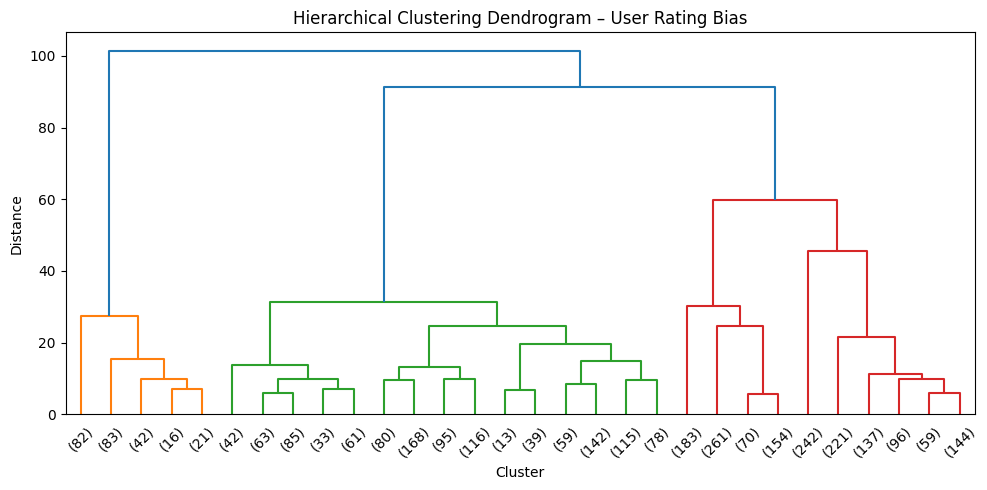

In [36]:

rng = np.random.default_rng(42)
sample_idx = rng.choice(
    XB_users.shape[0],
    size=3000,
    replace=False
)

XB_sample = XB_users[sample_idx]

Z = linkage(XB_sample, method="ward")

plt.figure(figsize=(10,5))
dendrogram(Z, truncate_mode="lastp", p=30)
plt.title("Hierarchical Clustering Dendrogram – User Rating Bias")
plt.xlabel("Cluster")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [38]:

rng = np.random.default_rng(42)
sample_size = 20000
sample_idx = rng.choice(XB_users.shape[0], size=sample_size, replace=False)
XB_sample = XB_users[sample_idx]


hclust = AgglomerativeClustering(n_clusters=3, linkage="ward")
labels_sample = hclust.fit_predict(XB_sample)


centroids = np.vstack([XB_sample[labels_sample == c].mean(axis=0) for c in range(3)])

print("Sample clustered:", XB_sample.shape, "| Centroids shape:", centroids.shape)

dists = ((XB_users[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2)
labels_B_users = dists.argmin(axis=1)

user_stats["cluster_B_user"] = labels_B_users

print("Assigned full users:", labels_B_users.shape)
user_stats["cluster_B_user"].value_counts()

cluster_profile_B_users = (
    user_stats
    .groupby("cluster_B_user")[features_B_users]
    .mean()
)

display(cluster_profile_B_users)


Sample clustered: (20000, 5) | Centroids shape: (3, 5)
Assigned full users: (427529,)


,avg_rating,std_rating,min_rating,max_rating,generosity
cluster_B_user,,,,,
0,4.071298,0.357766,3.629515,4.440578,1.071298
1,3.445419,1.121434,1.621468,4.770786,0.445419
2,1.813974,0.280130,1.549432,2.050077,-1.186026


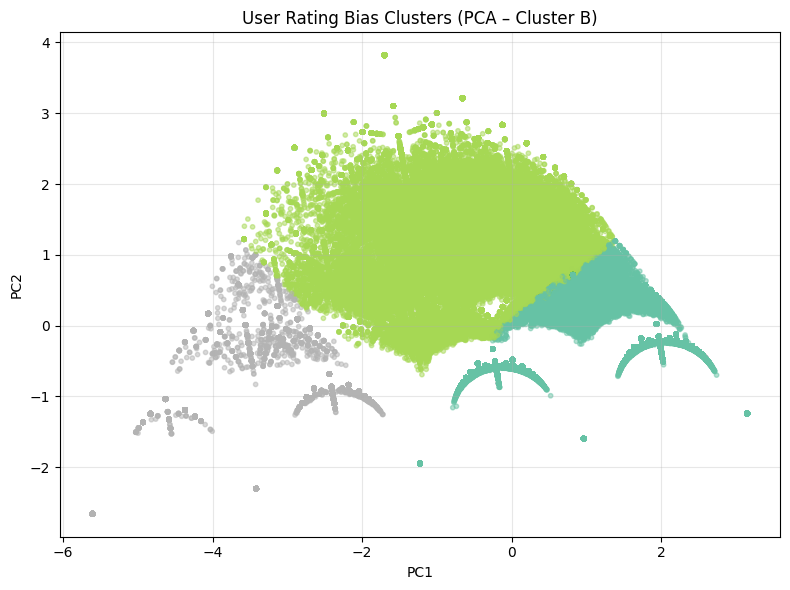

In [39]:

pca = PCA(n_components=2)
XB_users_pca = pca.fit_transform(XB_users)

plt.figure(figsize=(8,6))
plt.scatter(
    XB_users_pca[:,0],
    XB_users_pca[:,1],
    c=labels_B_users,
    cmap="Set2",
    alpha=0.5,
    s=10
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("User Rating Bias Clusters (PCA – Cluster B)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


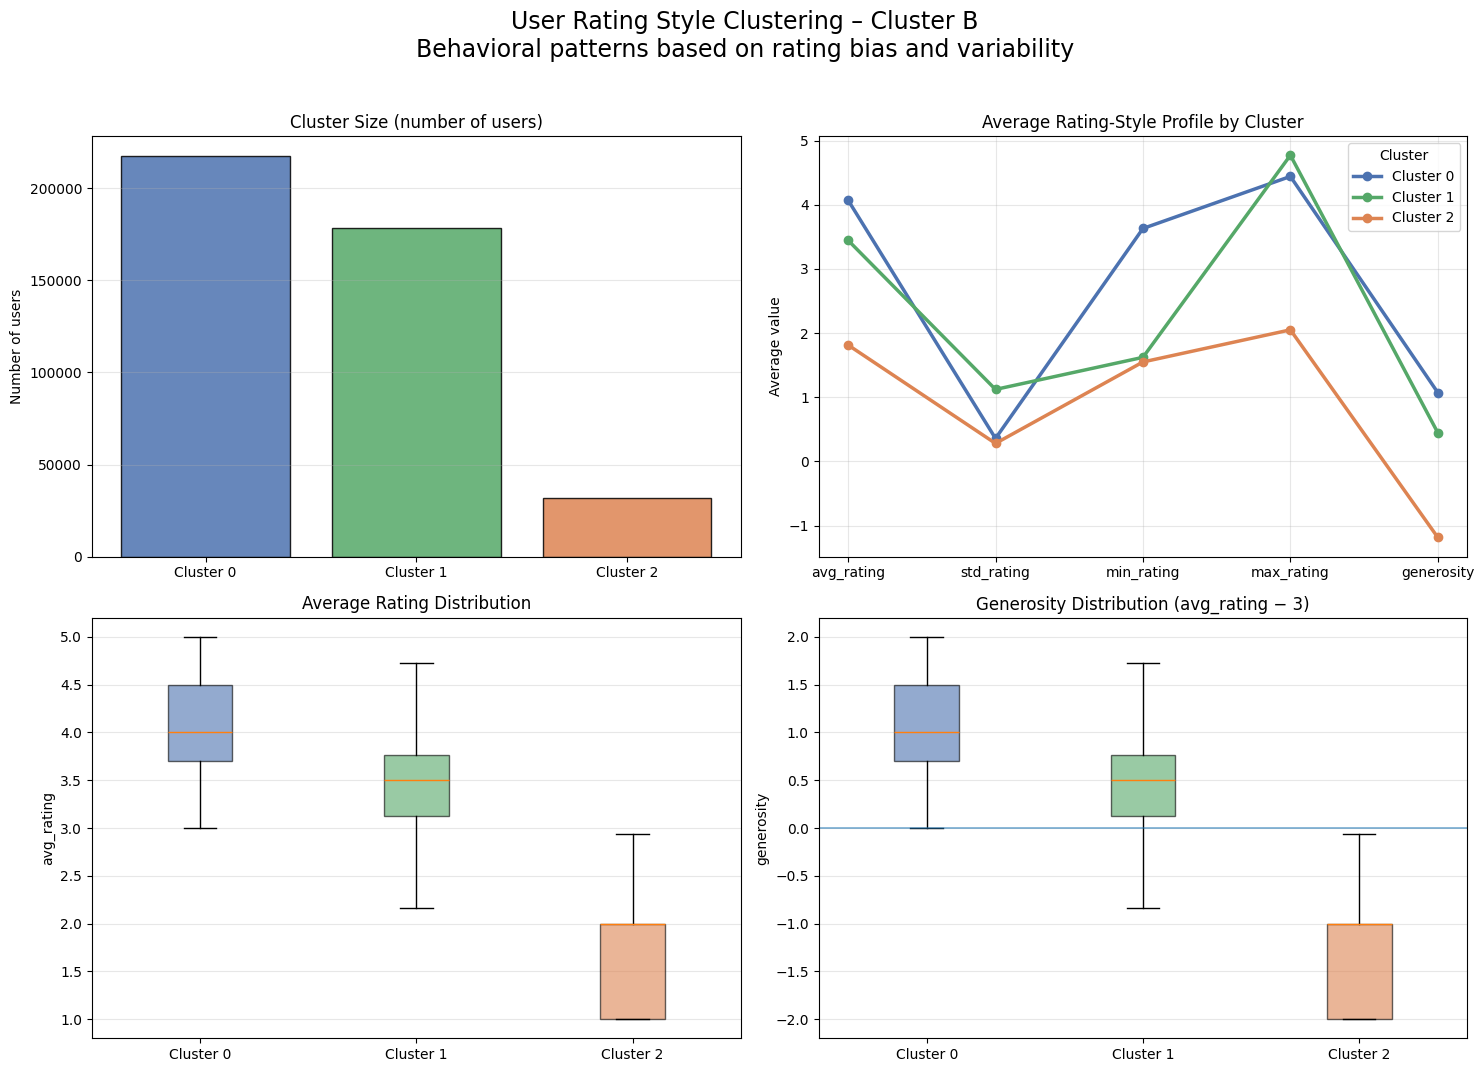

In [40]:


clusters = sorted(user_stats["cluster_B_user"].unique())
features = features_B_users

cluster_names_B = {
    0: "Cluster 0",
    1: "Cluster 1",
    2: "Cluster 2"
}

cluster_colors_B = {
    0: "#4C72B0",
    1: "#55A868",
    2: "#DD8452"
}

cluster_size = user_stats["cluster_B_user"].value_counts().sort_index()
cluster_mean = user_stats.groupby("cluster_B_user")[features].mean()


fig, axes = plt.subplots(2, 2, figsize=(15, 11))
fig.suptitle(
    "User Rating Style Clustering – Cluster B\n"
    "Behavioral patterns based on rating bias and variability",
    fontsize=17,
    y=0.97
)


ax = axes[0, 0]
ax.bar(
    cluster_size.index,
    cluster_size.values,
    color=[cluster_colors_B[c] for c in cluster_size.index],
    edgecolor="black",
    alpha=0.85
)
ax.set_title("Cluster Size (number of users)")
ax.set_xticks(cluster_size.index)
ax.set_xticklabels([cluster_names_B[c] for c in cluster_size.index])
ax.set_ylabel("Number of users")
ax.grid(axis="y", alpha=0.3)


ax = axes[0, 1]
for c in cluster_mean.index:
    ax.plot(
        features,
        cluster_mean.loc[c],
        marker="o",
        linewidth=2.5,
        label=cluster_names_B[c],
        color=cluster_colors_B[c]
    )
ax.set_title("Average Rating-Style Profile by Cluster")
ax.set_ylabel("Average value")
ax.grid(alpha=0.3)
ax.legend(title="Cluster")


ax = axes[1, 0]
data = [
    user_stats.loc[user_stats["cluster_B_user"] == c, "avg_rating"]
    for c in clusters
]
bp = ax.boxplot(
    data,
    labels=[cluster_names_B[c] for c in clusters],
    patch_artist=True,
    showfliers=False
)
for patch, c in zip(bp["boxes"], clusters):
    patch.set_facecolor(cluster_colors_B[c])
    patch.set_alpha(0.6)
    patch.set_edgecolor("black")
ax.set_title("Average Rating Distribution")
ax.set_ylabel("avg_rating")
ax.grid(axis="y", alpha=0.3)


ax = axes[1, 1]
data = [
    user_stats.loc[user_stats["cluster_B_user"] == c, "generosity"]
    for c in clusters
]
bp = ax.boxplot(
    data,
    labels=[cluster_names_B[c] for c in clusters],
    patch_artist=True,
    showfliers=False
)
for patch, c in zip(bp["boxes"], clusters):
    patch.set_facecolor(cluster_colors_B[c])
    patch.set_alpha(0.6)
    patch.set_edgecolor("black")
ax.axhline(0, linewidth=1.2, alpha=0.6)
ax.set_title("Generosity Distribution (avg_rating − 3)")
ax.set_ylabel("generosity")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


CLUSTER B MOVIE

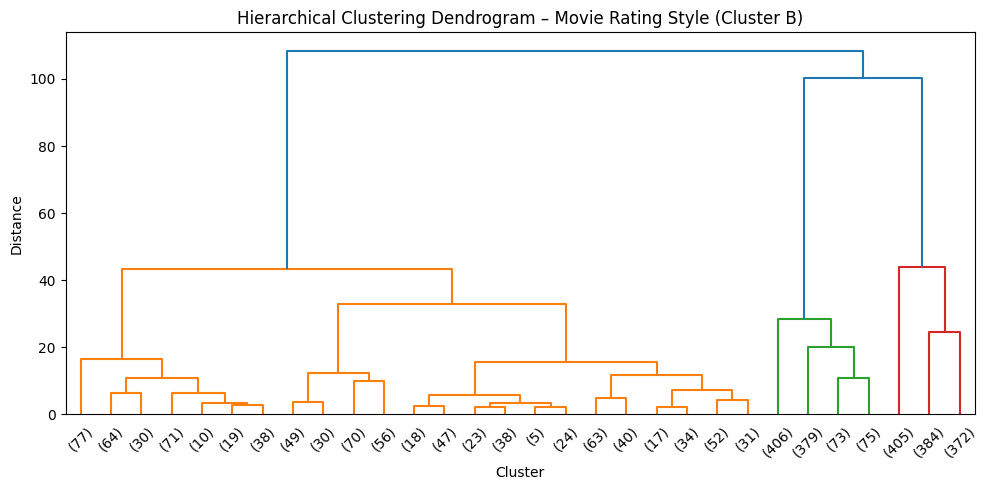

In [41]:

rng = np.random.default_rng(42)
sample_idx = rng.choice(
    XB_movies.shape[0],
    size=min(3000, XB_movies.shape[0]),
    replace=False
)

XB_sample = XB_movies[sample_idx]

Z = linkage(XB_sample, method="ward")

plt.figure(figsize=(10,5))
dendrogram(Z, truncate_mode="lastp", p=30)
plt.title("Hierarchical Clustering Dendrogram – Movie Rating Style (Cluster B)")
plt.xlabel("Cluster")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [42]:


rng = np.random.default_rng(42)
sample_size = min(20000, XB_movies.shape[0])
sample_idx = rng.choice(XB_movies.shape[0], size=sample_size, replace=False)
XB_sample = XB_movies[sample_idx]


hclust = AgglomerativeClustering(n_clusters=3, linkage="ward")
labels_sample = hclust.fit_predict(XB_sample)

centroids = np.vstack([XB_sample[labels_sample == c].mean(axis=0) for c in range(3)])


dists = ((XB_movies[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2)
labels_B_movies = dists.argmin(axis=1)

movie_stats["cluster_B_movie"] = labels_B_movies

print("Assigned full movies:", labels_B_movies.shape)
movie_stats["cluster_B_movie"].value_counts()

cluster_profile_B_movies = (
    movie_stats
    .groupby("cluster_B_movie")[features_B_movies]
    .mean()
)

display(cluster_profile_B_movies)

Assigned full movies: (14531,)


,avg_rating,std_rating,min_rating,max_rating,polarization
cluster_B_movie,,,,,
0,4.037328,0.076324,3.980104,4.092875,0.076324
1,3.016441,1.561440,1.513333,4.429057,1.561440
2,1.474670,0.060691,1.430205,1.520724,0.060691


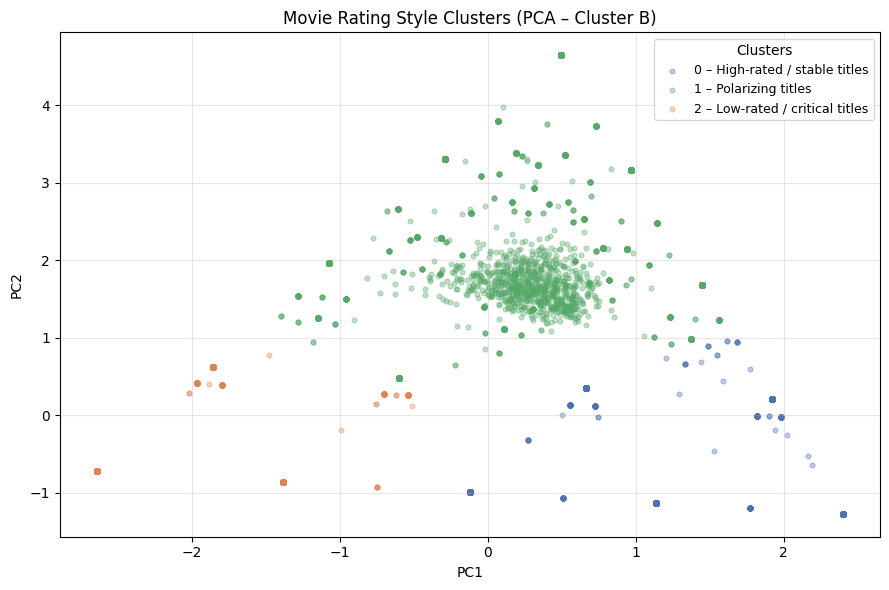

In [43]:

if "labels_B_movies" in globals():
    movie_stats["cluster_B_movie"] = labels_B_movies
else:
    labels_B_movies = movie_stats["cluster_B_movie"].to_numpy()


var_feat = "std_rating" if "std_rating" in movie_stats.columns else "polarization"
assert "avg_rating" in movie_stats.columns, "avg_rating non trovato in movie_stats"


profile = movie_stats.groupby("cluster_B_movie")[["avg_rating", var_feat]].mean()

clusters = list(profile.index)

polarizing_c = profile[var_feat].idxmax()
remaining = [c for c in clusters if c != polarizing_c]

if len(remaining) == 2:
    high_c = profile.loc[remaining, "avg_rating"].idxmax()
    low_c  = [c for c in remaining if c != high_c][0]
else:

    high_c = profile["avg_rating"].idxmax()
    low_c  = profile["avg_rating"].idxmin()

cluster_names_B = {c: f"Cluster {int(c)}" for c in clusters}
cluster_names_B[polarizing_c] = "Polarizing titles"
cluster_names_B[high_c] = "High-rated / stable titles"
cluster_names_B[low_c]  = "Low-rated / critical titles"


base_colors = ["#4C72B0", "#55A868", "#DD8452", "#C44E52", "#8172B3"]
cluster_colors_B = {c: base_colors[i % len(base_colors)] for i, c in enumerate(sorted(clusters))}


from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
XB_movies_pca = pca.fit_transform(XB_movies)

plt.figure(figsize=(9, 6))
for c in sorted(clusters):
    idx = labels_B_movies == c
    plt.scatter(
        XB_movies_pca[idx, 0],
        XB_movies_pca[idx, 1],
        s=12,
        alpha=0.35,
        c=cluster_colors_B[c],
        label=f"{int(c)} – {cluster_names_B[c]}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Movie Rating Style Clusters (PCA – Cluster B)")
plt.grid(True, alpha=0.3)
plt.legend(title="Clusters", fontsize=9)
plt.tight_layout()
plt.show()


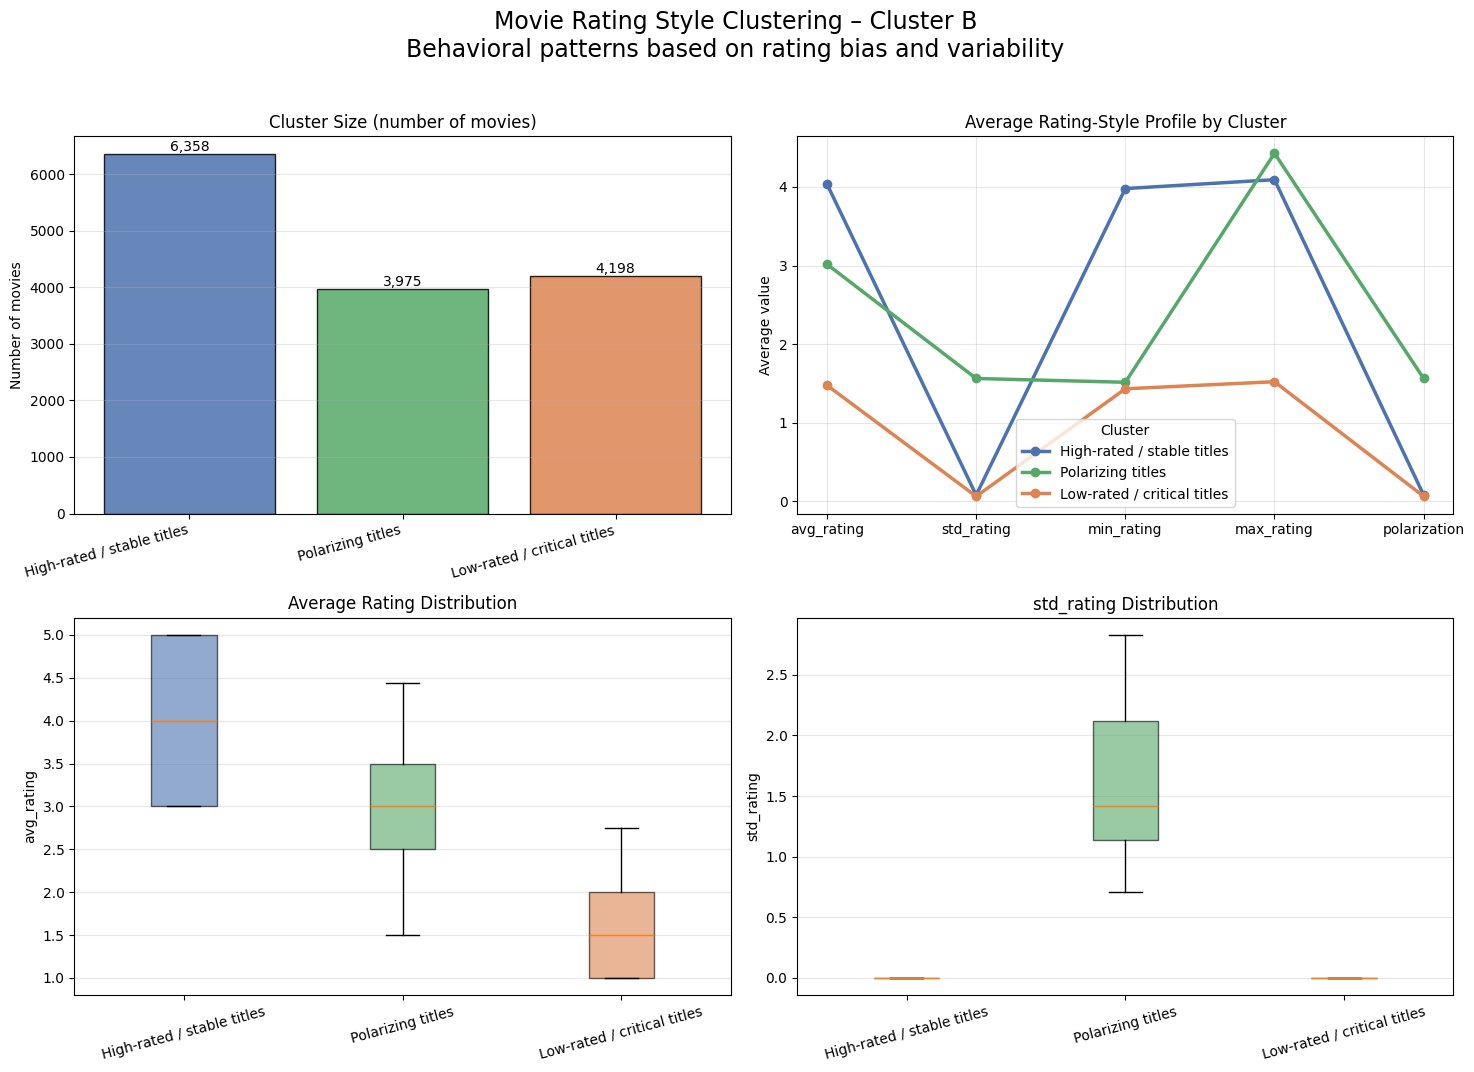

In [44]:


if "labels_B_movies" in globals():
    movie_stats["cluster_B_movie"] = labels_B_movies
else:
    assert "cluster_B_movie" in movie_stats.columns
    labels_B_movies = movie_stats["cluster_B_movie"].to_numpy()

clusters = sorted(movie_stats["cluster_B_movie"].unique())


var_feat = "std_rating" if "std_rating" in movie_stats.columns else "polarization"
assert "avg_rating" in movie_stats.columns, "avg_rating non trovato in movie_stats"


profile = movie_stats.groupby("cluster_B_movie")[["avg_rating", var_feat]].mean()

polarizing_c = profile[var_feat].idxmax()
remaining = [c for c in clusters if c != polarizing_c]

if len(remaining) == 2:
    high_c = profile.loc[remaining, "avg_rating"].idxmax()
    low_c  = [c for c in remaining if c != high_c][0]
else:
    high_c = profile["avg_rating"].idxmax()
    low_c  = profile["avg_rating"].idxmin()

cluster_names_B = {c: f"Cluster {int(c)}" for c in clusters}
cluster_names_B[polarizing_c] = "Polarizing titles"
cluster_names_B[high_c] = "High-rated / stable titles"
cluster_names_B[low_c]  = "Low-rated / critical titles"


base_colors = ["#4C72B0", "#55A868", "#DD8452", "#C44E52", "#8172B3"]
cluster_colors_B = {c: base_colors[i % len(base_colors)] for i, c in enumerate(sorted(clusters))}


features = list(features_B_movies)
cluster_size = movie_stats["cluster_B_movie"].value_counts().sort_index()
cluster_mean = movie_stats.groupby("cluster_B_movie")[features].mean()


fig, axes = plt.subplots(2, 2, figsize=(15, 11))
fig.suptitle(
    "Movie Rating Style Clustering – Cluster B\n"
    "Behavioral patterns based on rating bias and variability",
    fontsize=17,
    y=0.97
)

# (1) Cluster size
ax = axes[0, 0]
order = list(cluster_size.index)
labels_x = [cluster_names_B[c] for c in order]

bars = ax.bar(
    np.arange(len(order)),
    cluster_size.values,
    color=[cluster_colors_B[c] for c in order],
    edgecolor="black",
    alpha=0.85
)
ax.set_title("Cluster Size (number of movies)")
ax.set_xticks(np.arange(len(order)))
ax.set_xticklabels(labels_x, rotation=15, ha="right")
ax.set_ylabel("Number of movies")
ax.grid(axis="y", alpha=0.3)
for b in bars:
    ax.text(b.get_x() + b.get_width()/2, b.get_height(), f"{int(b.get_height()):,}",
            ha="center", va="bottom", fontsize=10)

ax = axes[0, 1]
for c in order:
    ax.plot(
        features,
        cluster_mean.loc[c].values,
        marker="o",
        linewidth=2.5,
        label=cluster_names_B[c],
        color=cluster_colors_B[c]
    )
ax.set_title("Average Rating-Style Profile by Cluster")
ax.set_ylabel("Average value")
ax.grid(alpha=0.3)
ax.legend(title="Cluster")


ax = axes[1, 0]
data = [movie_stats.loc[movie_stats["cluster_B_movie"] == c, "avg_rating"].dropna() for c in order]
bp = ax.boxplot(
    data,
    labels=[cluster_names_B[c] for c in order],
    patch_artist=True,
    showfliers=False
)
for patch, c in zip(bp["boxes"], order):
    patch.set_facecolor(cluster_colors_B[c])
    patch.set_alpha(0.6)
    patch.set_edgecolor("black")
ax.set_title("Average Rating Distribution")
ax.set_ylabel("avg_rating")
ax.grid(axis="y", alpha=0.3)
ax.tick_params(axis="x", rotation=15)

ax = axes[1, 1]
data = [movie_stats.loc[movie_stats["cluster_B_movie"] == c, var_feat].dropna() for c in order]
bp = ax.boxplot(
    data,
    labels=[cluster_names_B[c] for c in order],
    patch_artist=True,
    showfliers=False
)
for patch, c in zip(bp["boxes"], order):
    patch.set_facecolor(cluster_colors_B[c])
    patch.set_alpha(0.6)
    patch.set_edgecolor("black")
ax.set_title(f"{var_feat} Distribution")
ax.set_ylabel(var_feat)
ax.grid(axis="y", alpha=0.3)
ax.tick_params(axis="x", rotation=15)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


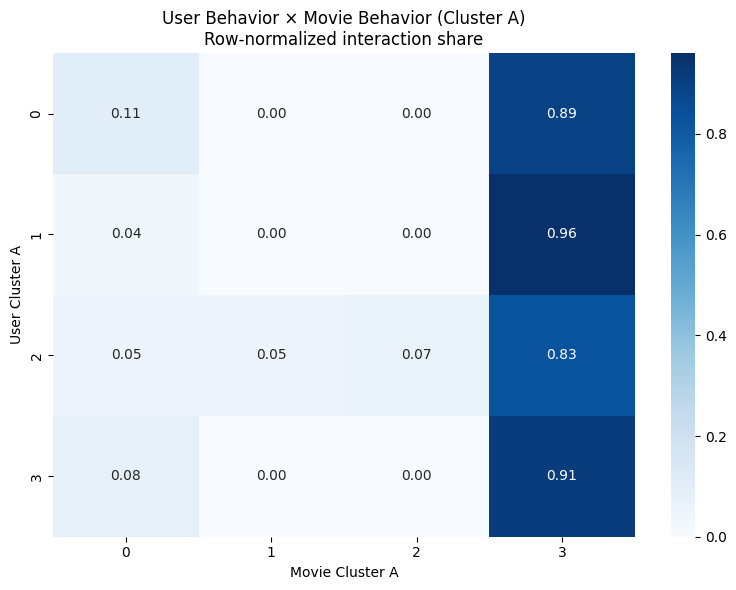

In [45]:

hm_AA = (
    events
    .merge(user_stats[["customer_id", "cluster_A_user"]], on="customer_id")
    .merge(movie_stats[["movie_id", "cluster_A_movie"]], on="movie_id")
    .groupby(["cluster_A_user", "cluster_A_movie"])
    .size()
    .reset_index(name="interactions")
)


hm_AA_pivot = hm_AA.pivot(
    index="cluster_A_user",
    columns="cluster_A_movie",
    values="interactions"
).fillna(0)


hm_AA_norm = hm_AA_pivot.div(hm_AA_pivot.sum(axis=1), axis=0)

plt.figure(figsize=(8,6))
sns.heatmap(
    hm_AA_norm,
    cmap="Blues",
    annot=True,
    fmt=".2f"
)
plt.title("User Behavior × Movie Behavior (Cluster A)\nRow-normalized interaction share")
plt.xlabel("Movie Cluster A")
plt.ylabel("User Cluster A")
plt.tight_layout()
plt.show()


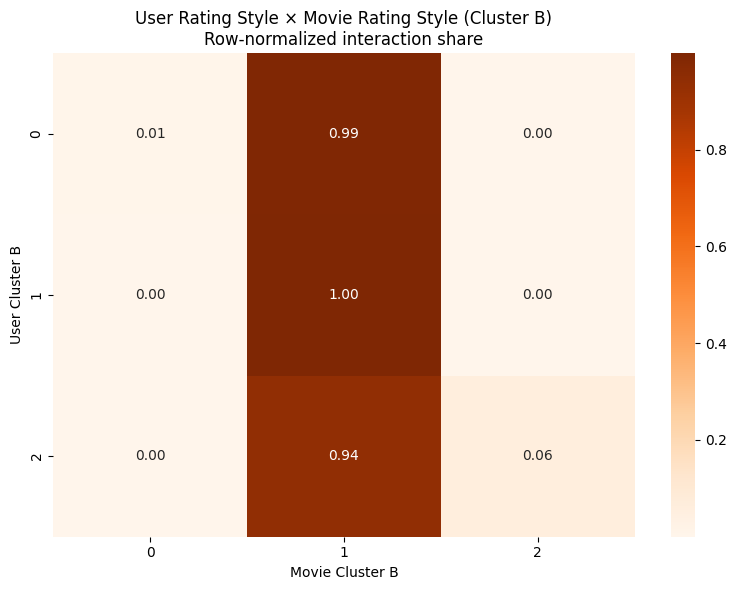

In [46]:


hm_BB = (
    events
    .merge(user_stats[["customer_id", "cluster_B_user"]], on="customer_id")
    .merge(movie_stats[["movie_id", "cluster_B_movie"]], on="movie_id")
    .groupby(["cluster_B_user", "cluster_B_movie"])
    .size()
    .reset_index(name="interactions")
)


hm_BB_pivot = hm_BB.pivot(
    index="cluster_B_user",
    columns="cluster_B_movie",
    values="interactions"
).fillna(0)


hm_BB_norm = hm_BB_pivot.div(hm_BB_pivot.sum(axis=1), axis=0)

plt.figure(figsize=(8,6))
sns.heatmap(
    hm_BB_norm,
    cmap="Oranges",
    annot=True,
    fmt=".2f"
)
plt.title("User Rating Style × Movie Rating Style (Cluster B)\nRow-normalized interaction share")
plt.xlabel("Movie Cluster B")
plt.ylabel("User Cluster B")
plt.tight_layout()
plt.show()
